In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

LLEGIR DADES SIMULADES

In [4]:
def read_img(path, shape):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data.reshape(shape)

INICIALITZACIÓ DE LES CAPES

In [5]:
shape = (50, 50)

# Carreguem les capes
vegetation = read_img('vegetation.img', shape)
humidity = read_img('humidity.img', shape)

# Estat de les cel·les: 0 = pendent, 1 = cremant, 2 = cremat
state = np.zeros(shape, dtype=int)

# Inicialitzem foc en diversos punts aleatoris
num_initial_fires = 10
initial_fire_coords = np.random.choice(np.arange(shape[0]*shape[1]), num_initial_fires, replace=False)
for idx in initial_fire_coords:
    i, j = divmod(idx, shape[1])
    state[i, j] = 1

# Capes auxiliars per controlar humitat i vegetació cremant
humidity_timer = np.zeros_like(humidity)
vegetation_timer = np.zeros_like(vegetation)


FUNCIÓ D'ACTUALITZACIÓ DEL FOC

In [6]:
def update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer):
    new_state = state.copy()
    new_humidity_timer = humidity_timer.copy()
    new_vegetation_timer = vegetation_timer.copy()

    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if state[i, j] == 1:  # Cel·la cremant
                new_vegetation_timer[i, j] += 1
                if new_vegetation_timer[i, j] >= vegetation[i, j]:
                    new_state[i, j] = 2  # Crema completada
            elif state[i, j] == 0:  # Cel·la pendent
                # Mirem els 8 veïns
                neighbors = [(i-1,j-1), (i-1,j), (i-1,j+1),
                             (i,j-1),           (i,j+1),
                             (i+1,j-1), (i+1,j), (i+1,j+1)]
                for ni, nj in neighbors:
                    if 0 <= ni < state.shape[0] and 0 <= nj < state.shape[1]:
                        if state[ni, nj] == 1:
                            new_humidity_timer[i, j] += 1
                            if new_humidity_timer[i, j] >= humidity[i, j]:
                                new_state[i, j] = 1  # Comença a cremar
                            break
    return new_state, new_humidity_timer, new_vegetation_timer

SIMULAR I VISUALITZAR

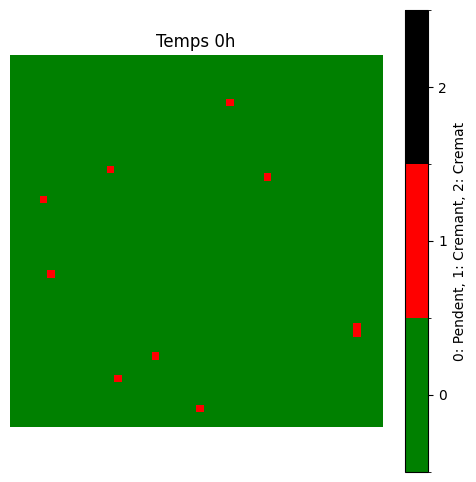

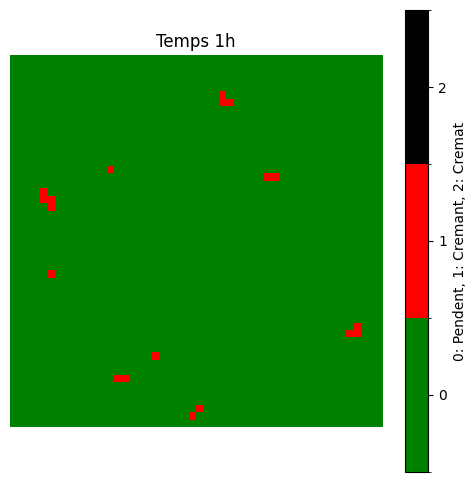

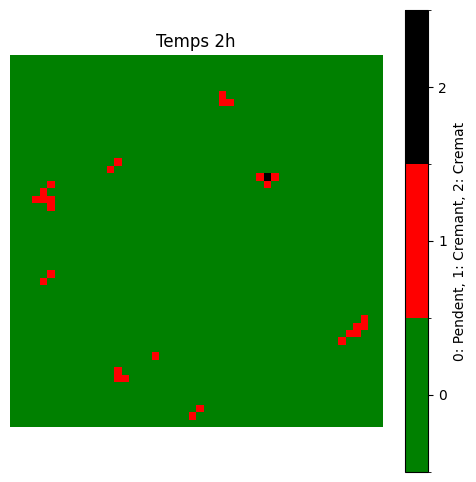

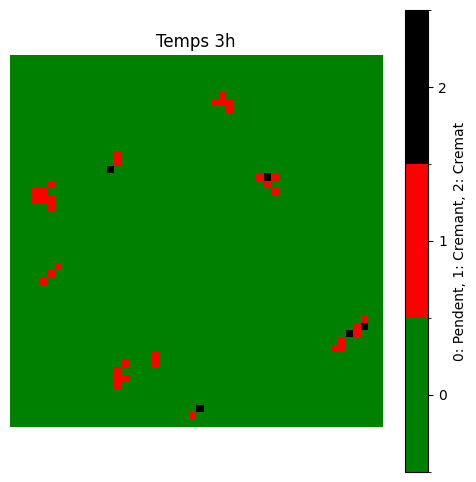

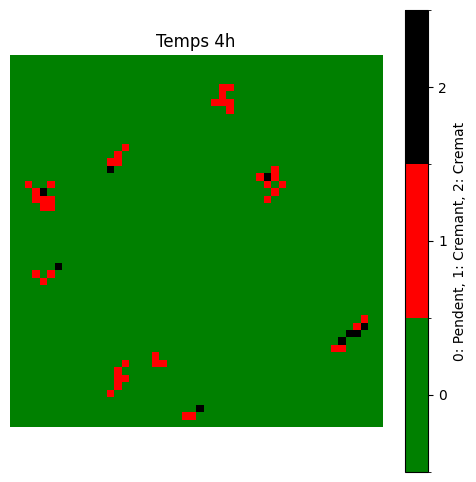

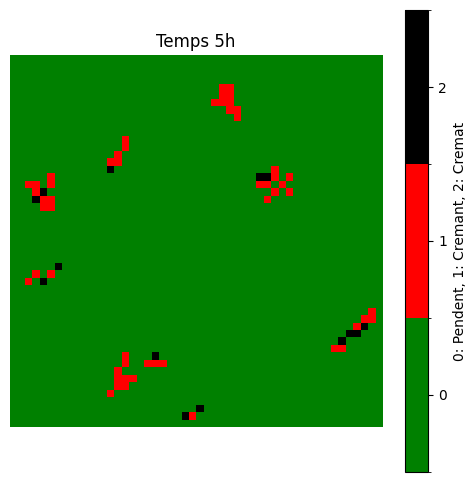

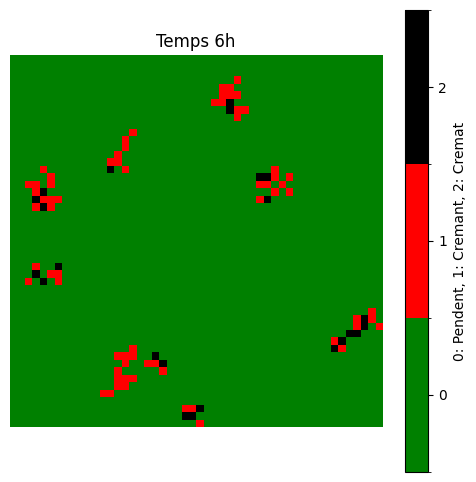

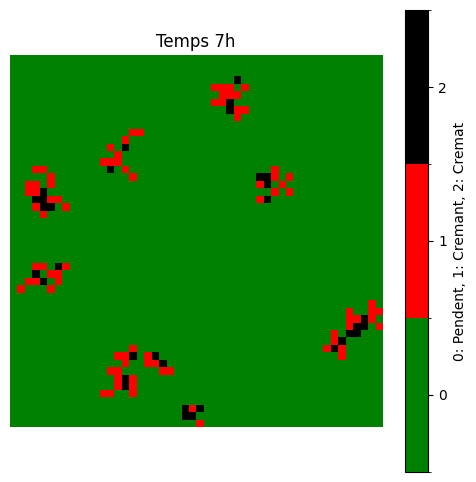

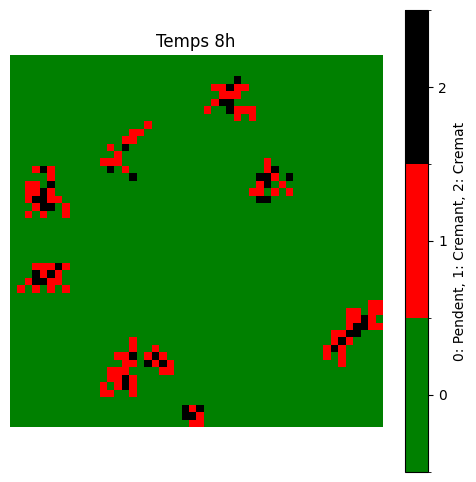

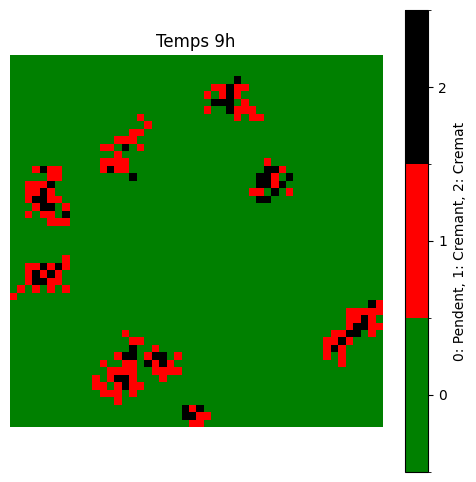

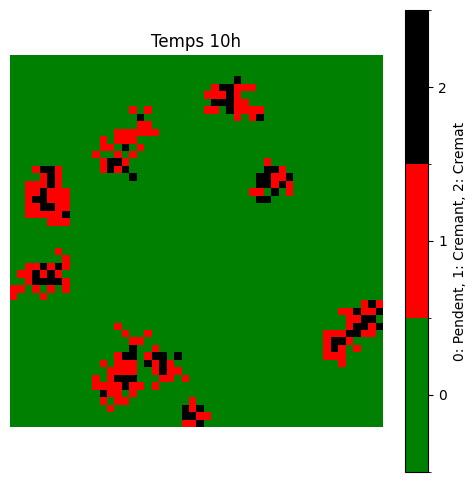

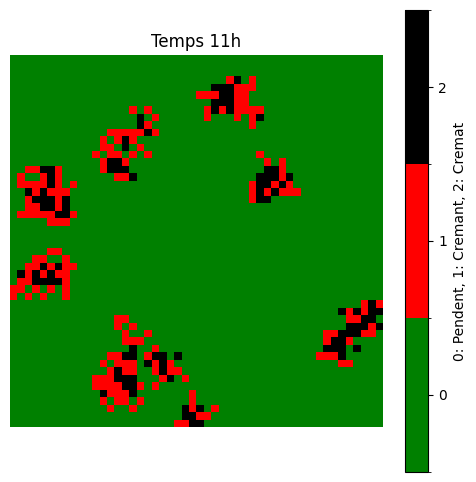

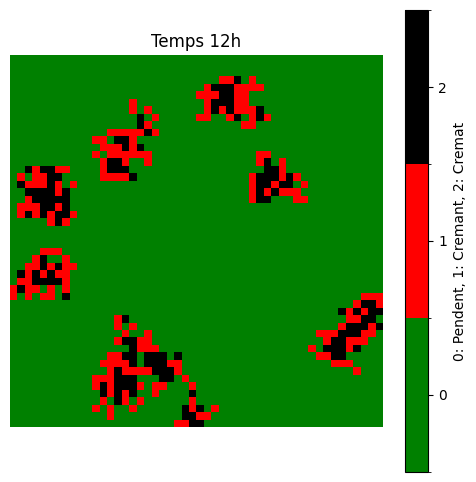

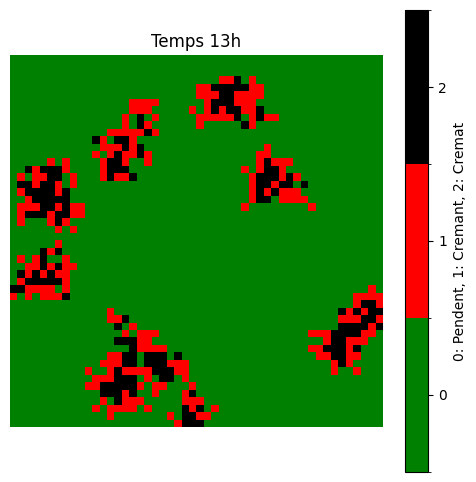

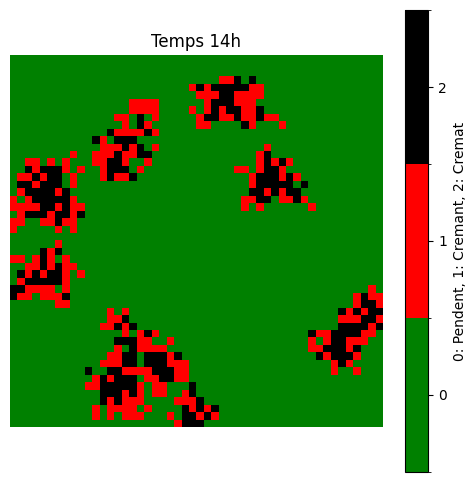

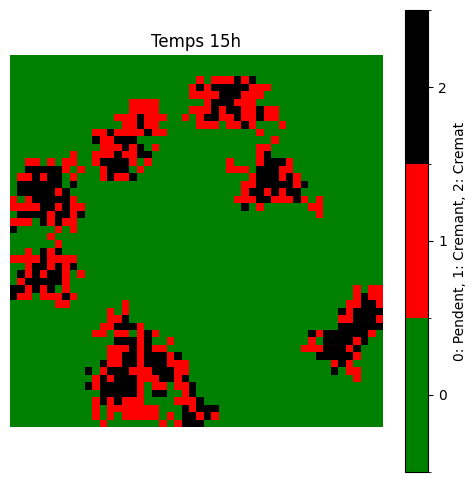

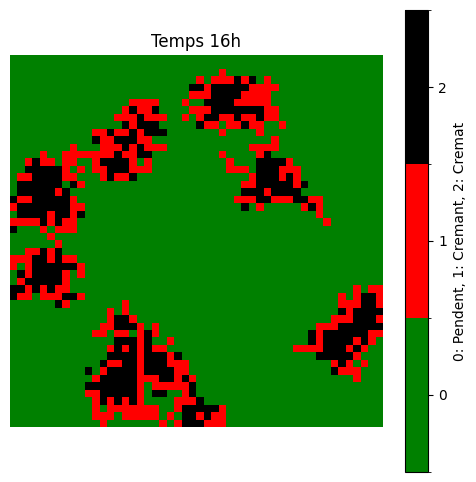

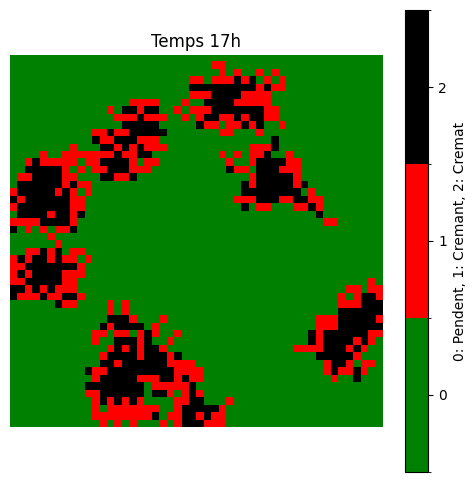

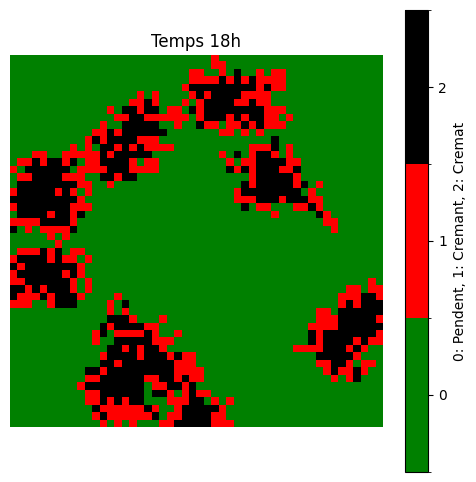

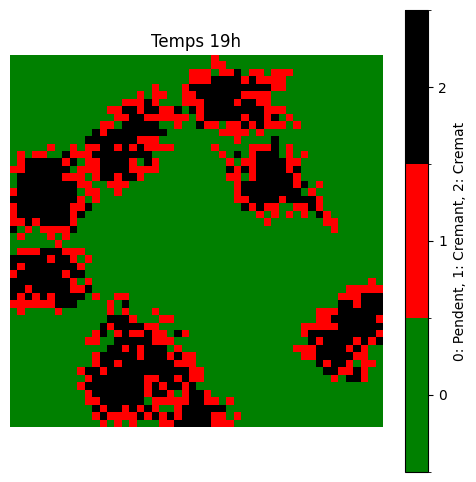

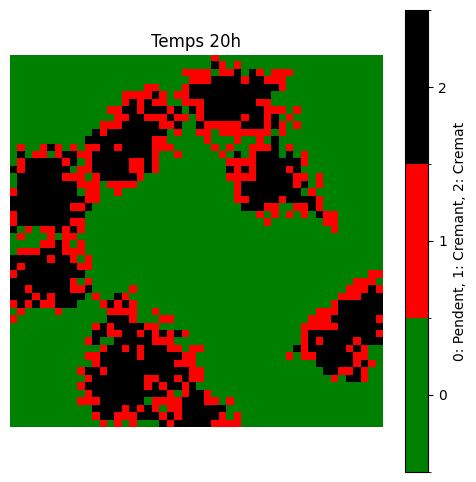

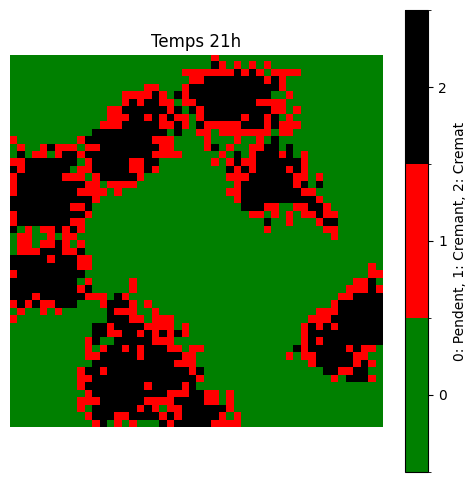

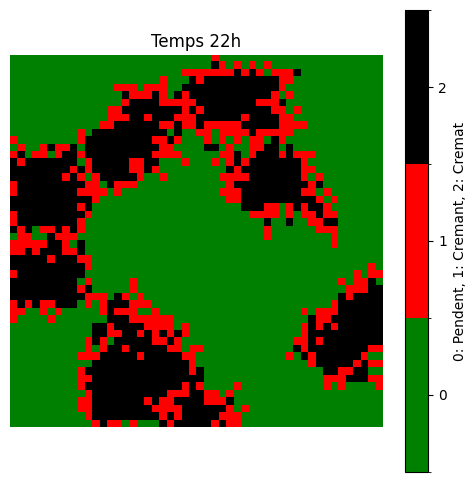

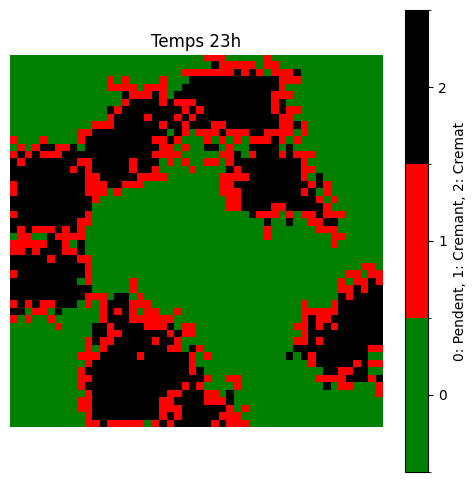

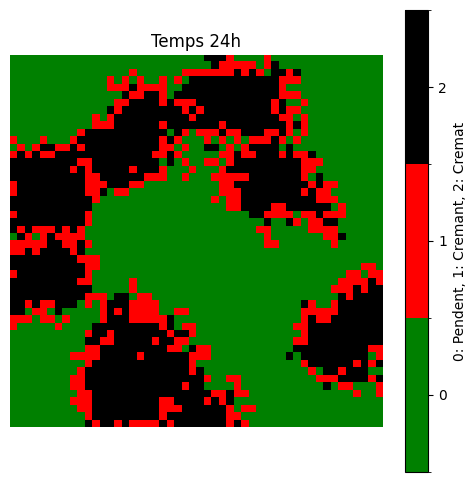

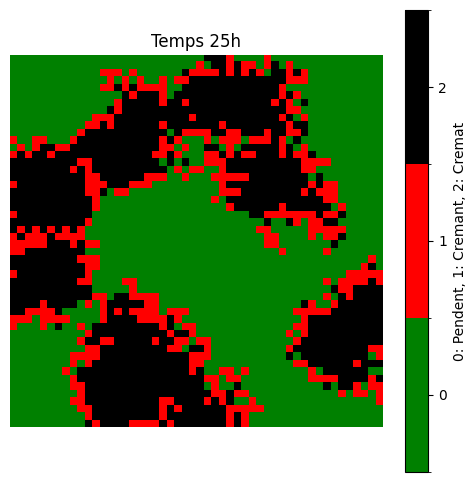

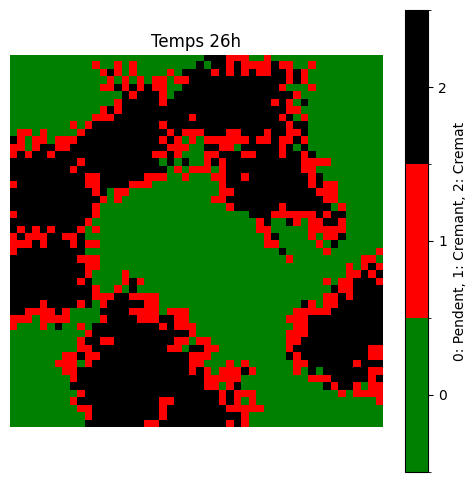

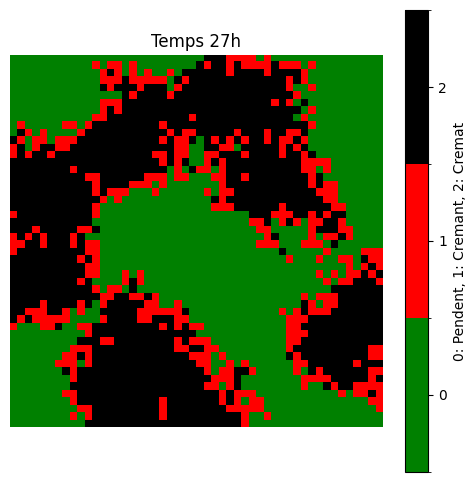

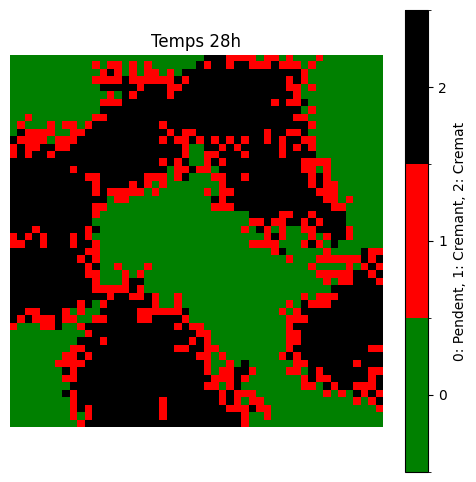

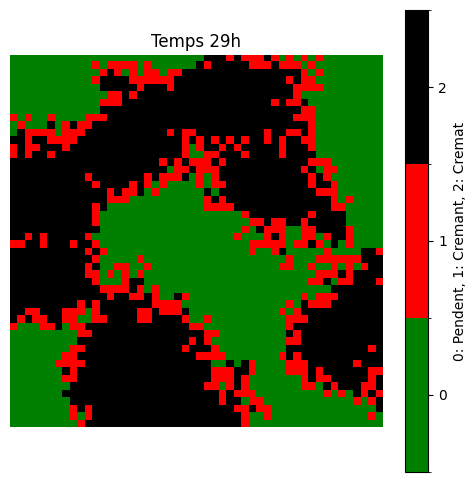

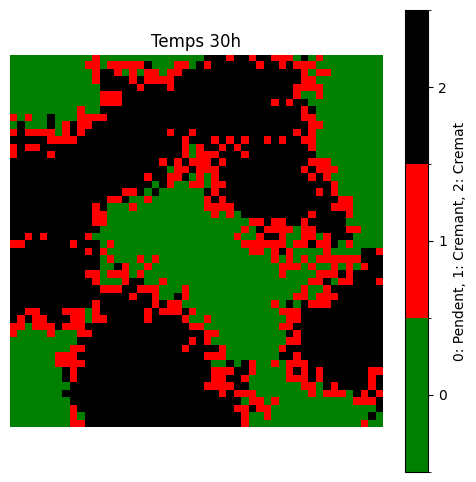

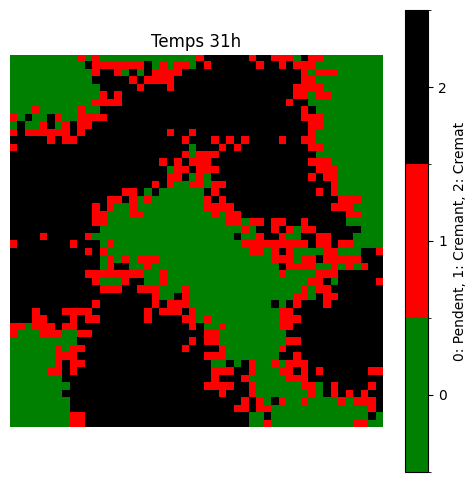

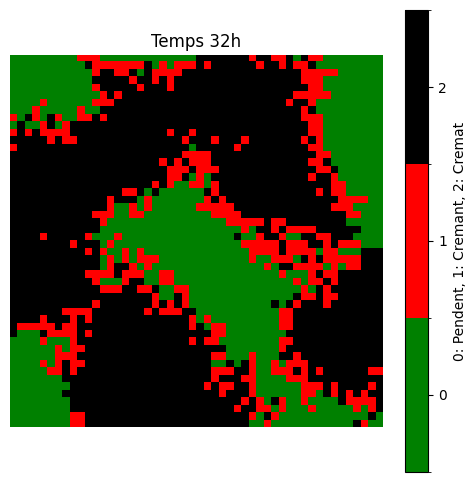

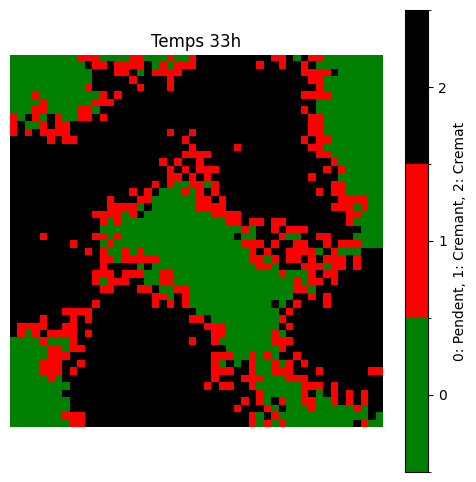

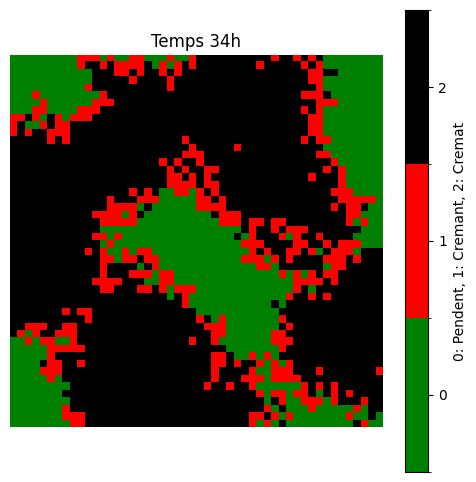

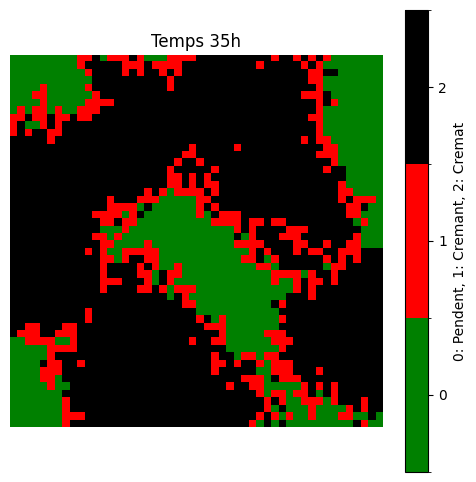

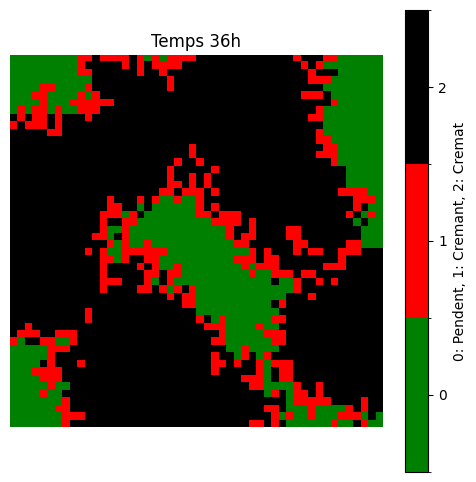

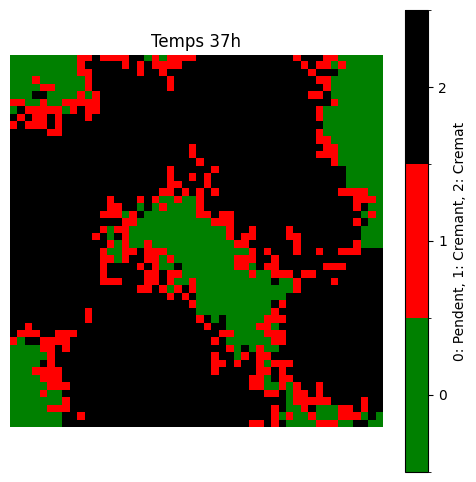

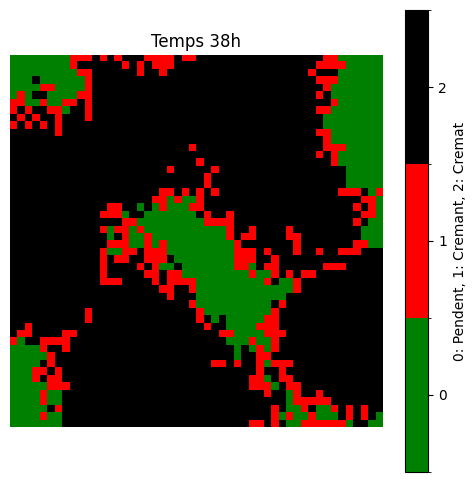

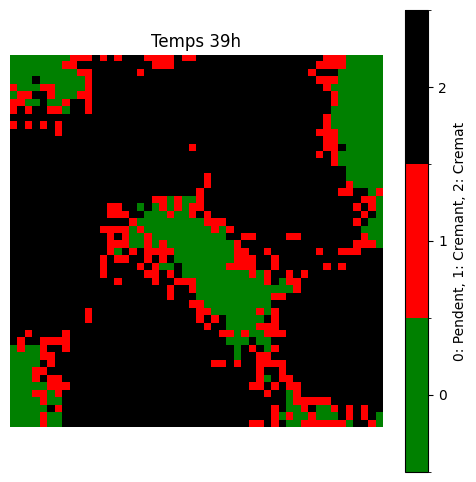

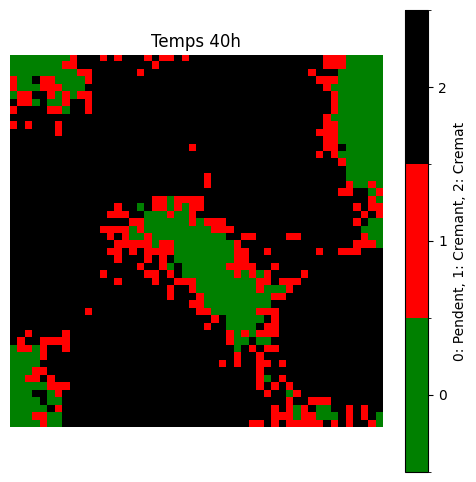

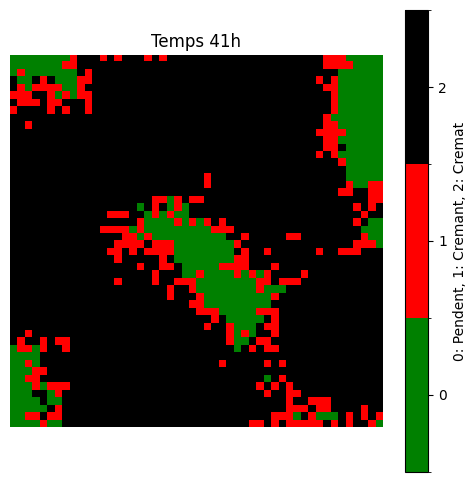

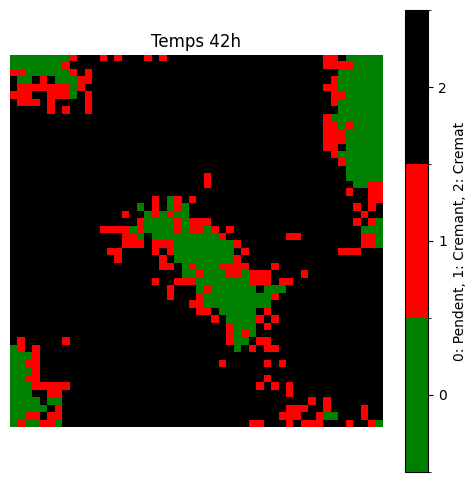

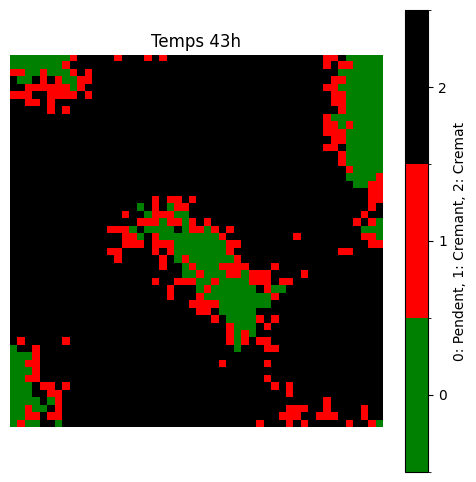

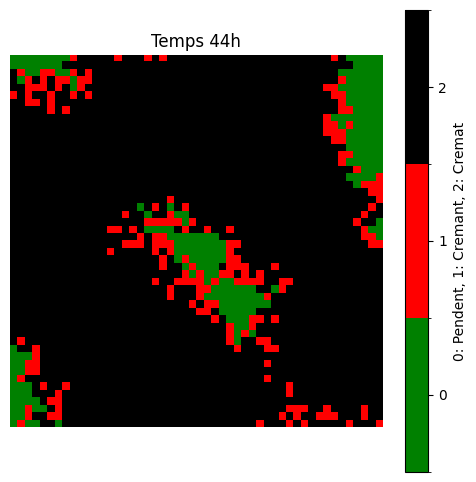

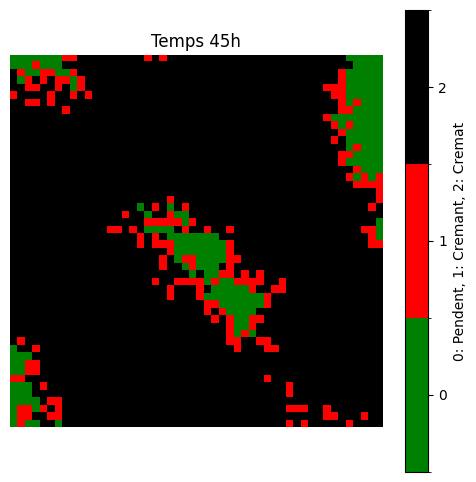

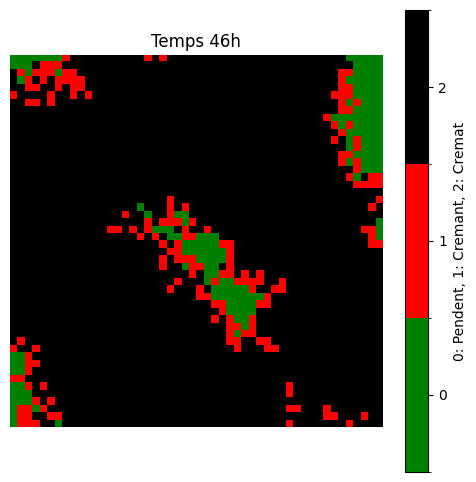

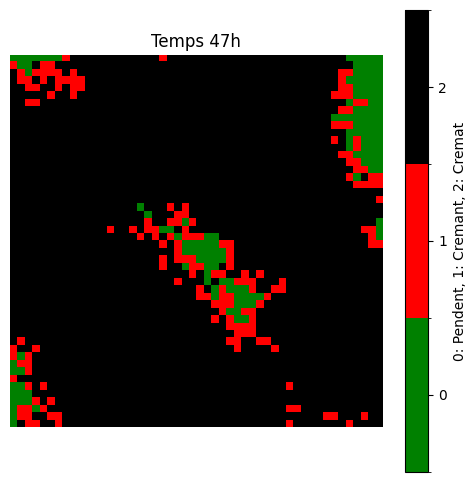

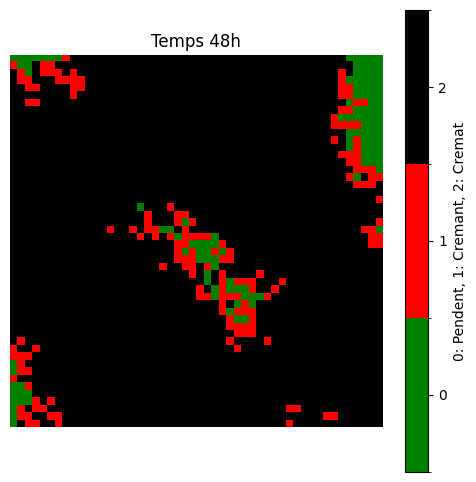

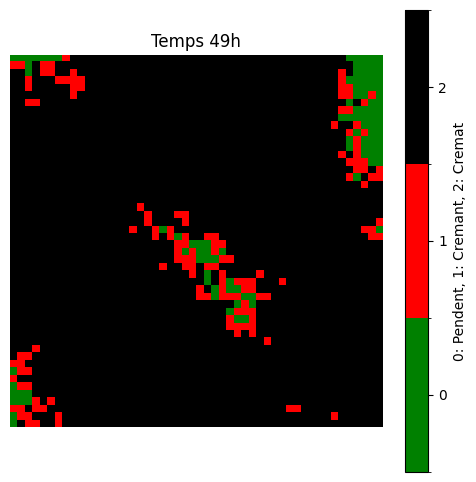

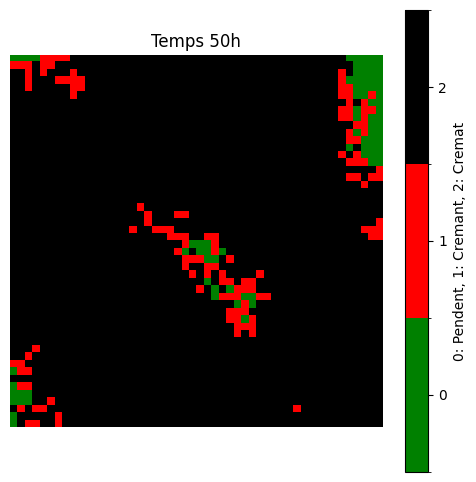

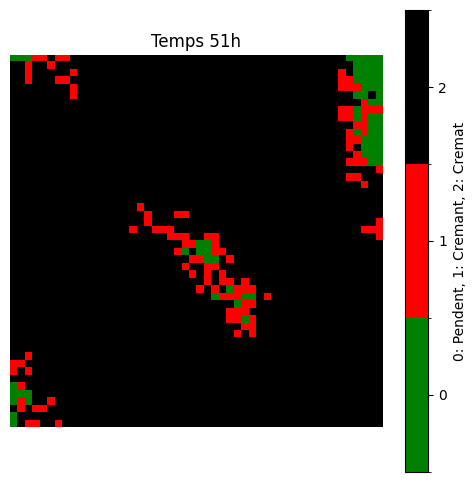

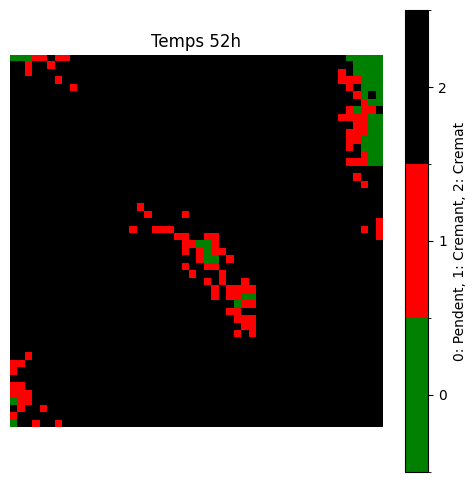

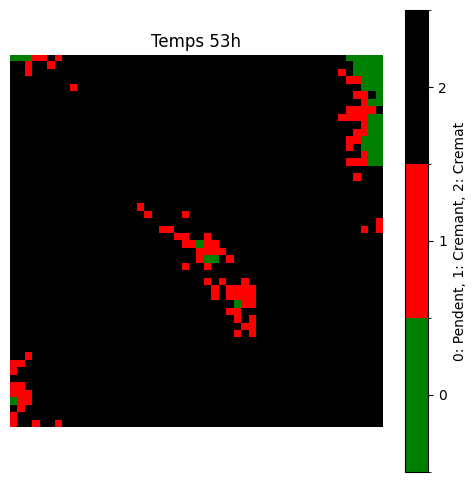

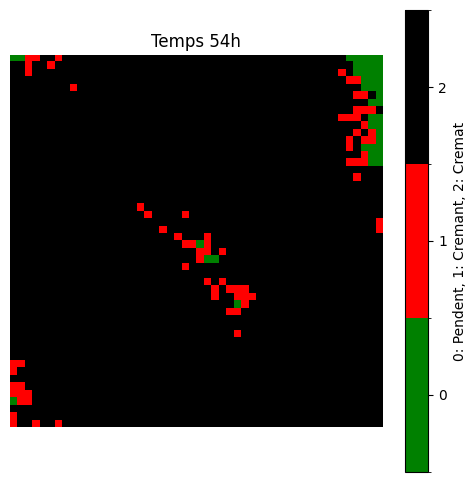

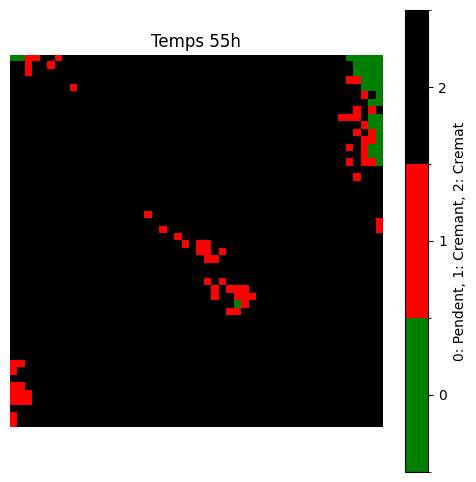

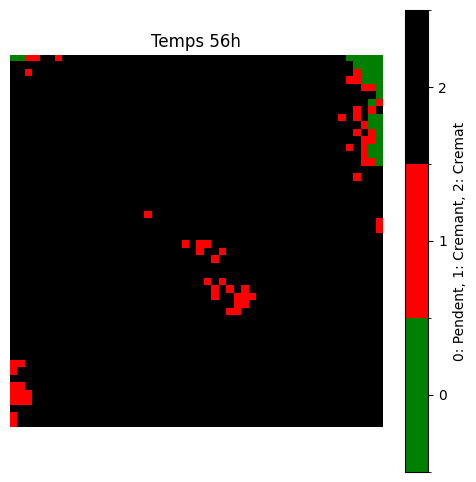

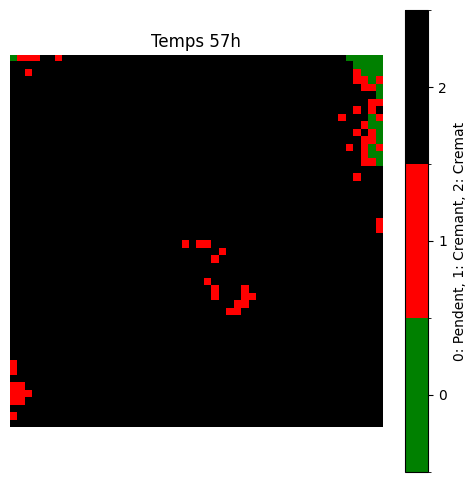

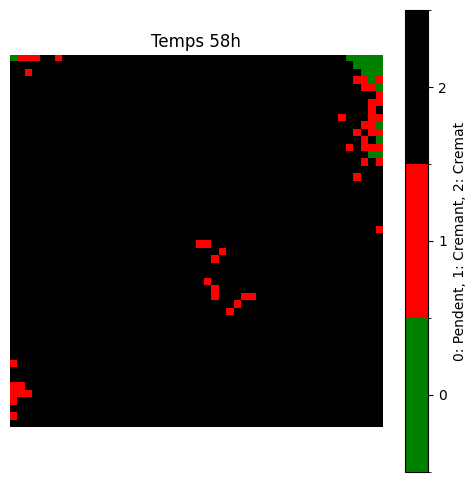

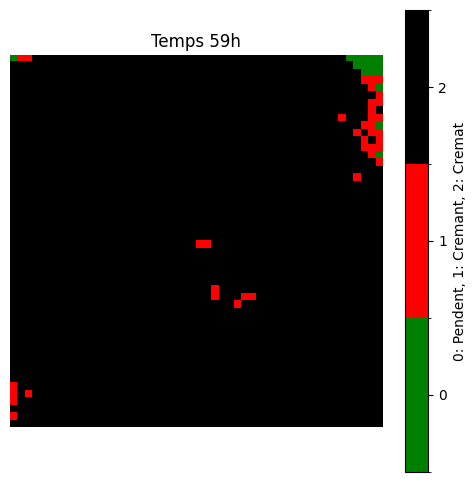

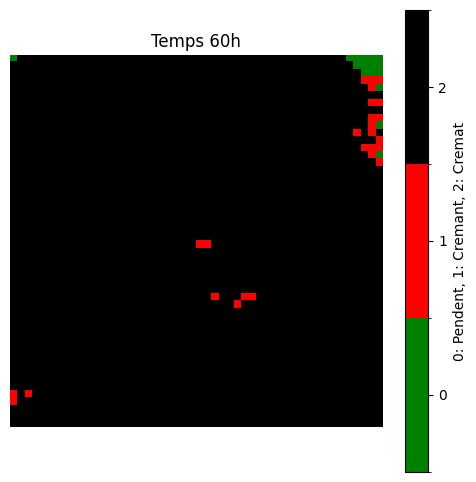

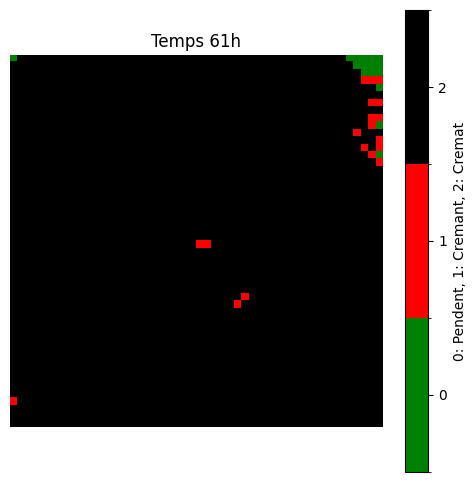

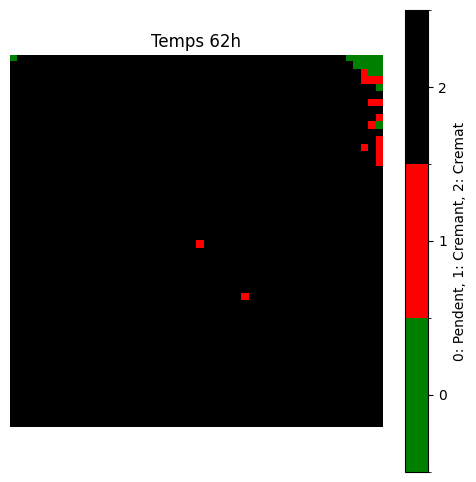

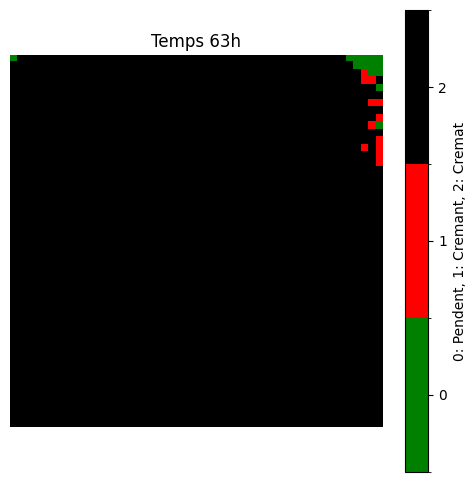

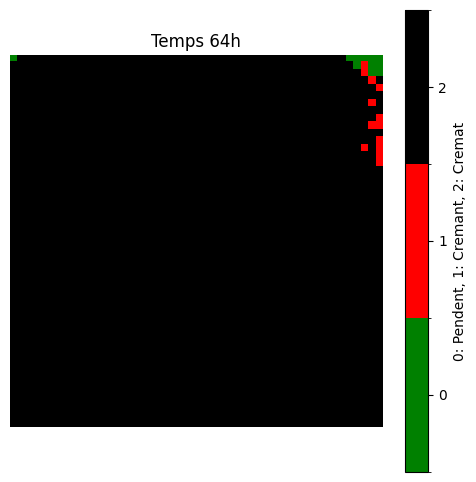

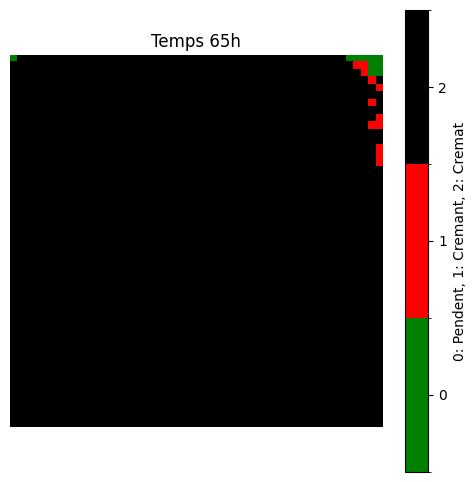

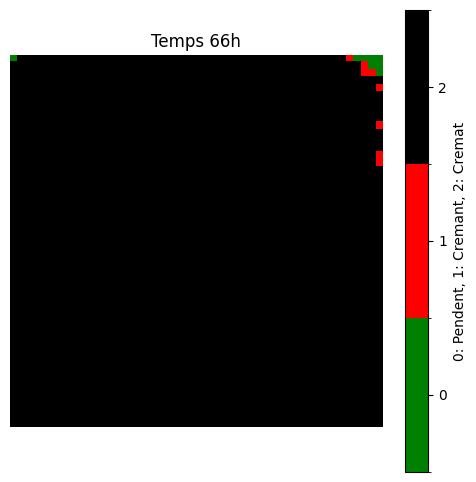

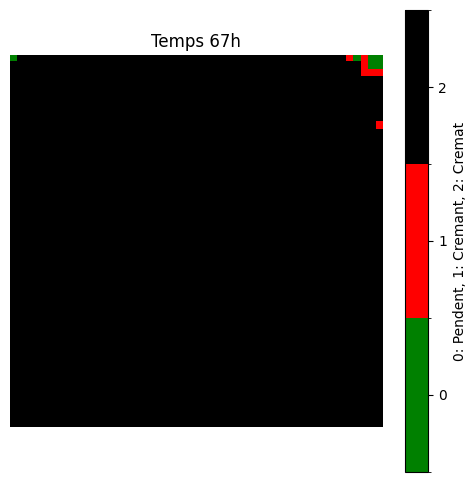

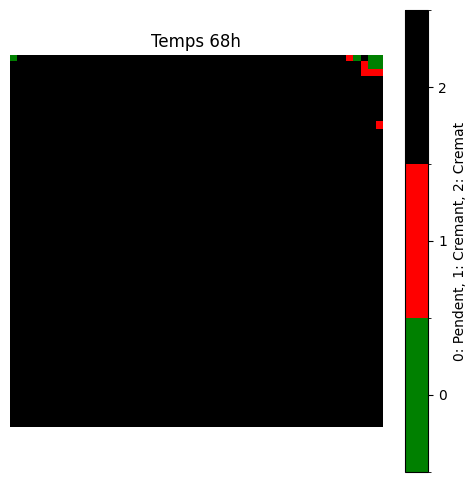

Incendi aturat per falta de propagació en 68 hores.


In [7]:
# === 4. Funció per visualitzar l'estat ===
def plot_state(state, step):
    cmap = colors.ListedColormap(['green', 'red', 'black'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(6,6))
    plt.imshow(state, cmap=cmap, norm=norm)
    plt.title(f'Temps {step}h')
    plt.colorbar(ticks=[0,1,2], label='0: Pendent, 1: Cremant, 2: Cremat')
    plt.axis('off')
    plt.show()

# === 5. Simulació ===
max_steps = 100
for step in range(max_steps):
    plot_state(state, step)
    next_state, next_humidity_timer, next_vegetation_timer = update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer)

    # Comprovem si hi ha canvi
    if np.array_equal(next_state, state):
        print(f"Incendi aturat per falta de propagació en {step} hores.")
        break

    state = next_state
    humidity_timer = next_humidity_timer
    vegetation_timer = next_vegetation_timer


PART OPTATIVA: vent

Si el veí està a la direcció del vent, augmentem el comptador de humitat el doble (+2).

Si qualsevol altre veí està cremant, increment normal (+1).

Direcció del vent escollida: Sud (↓)


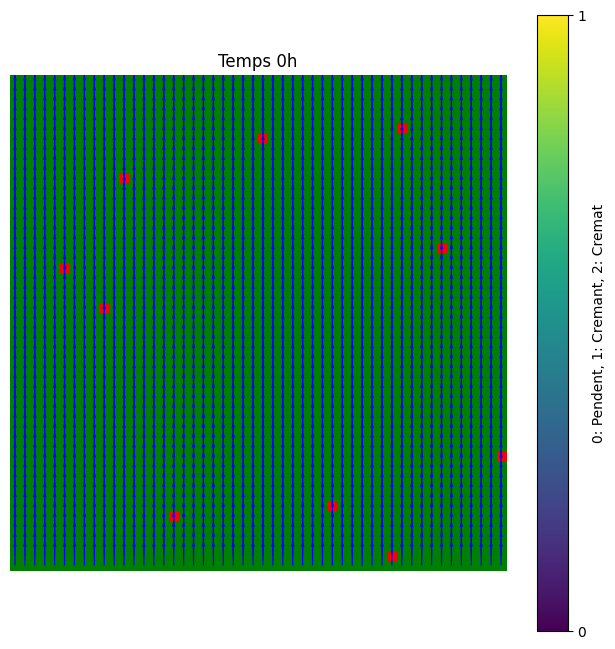

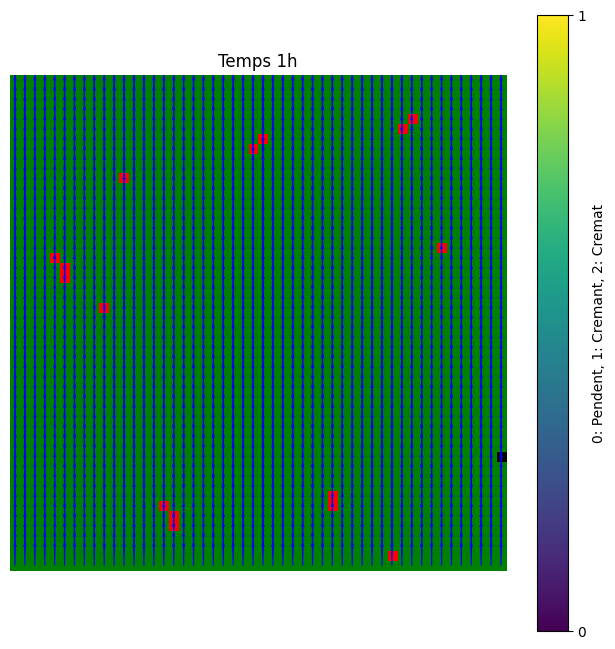

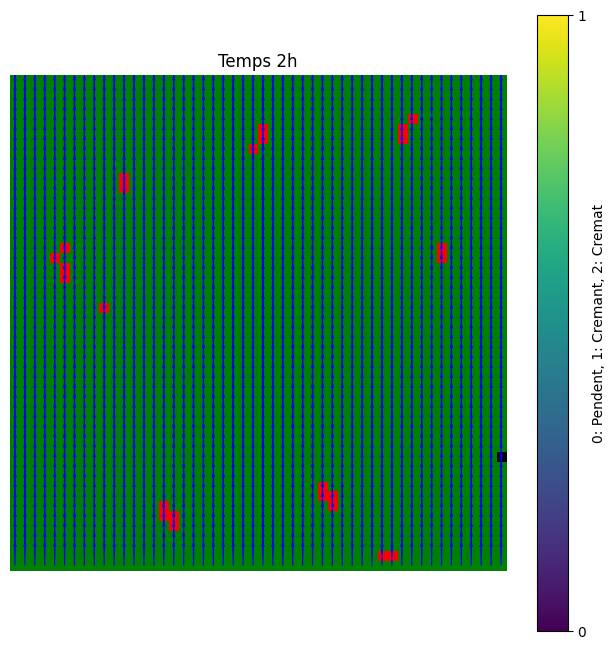

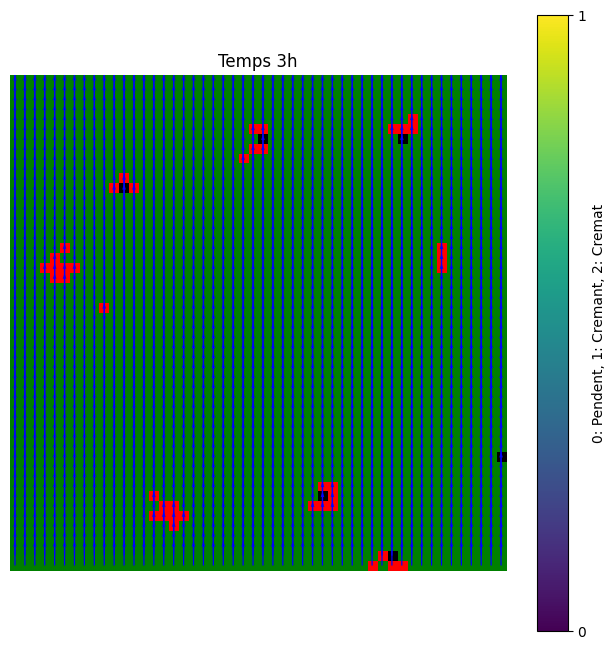

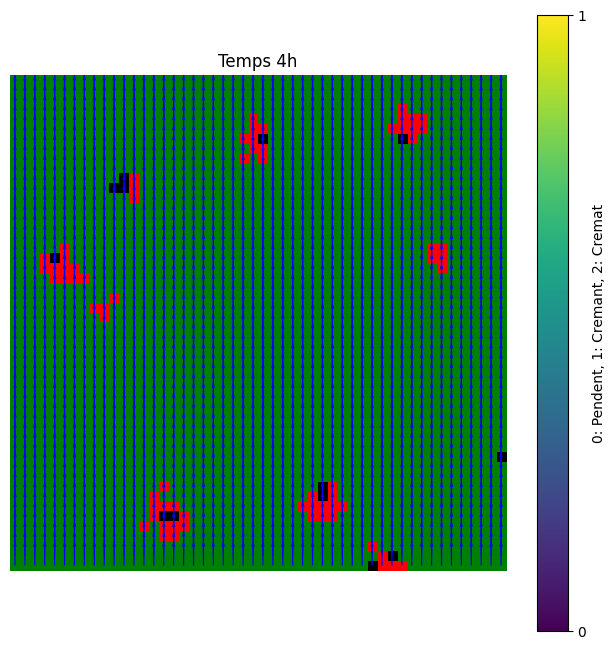

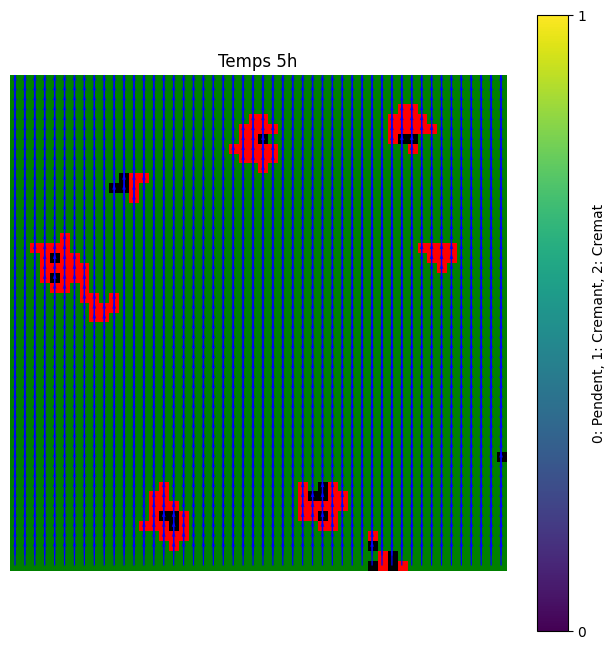

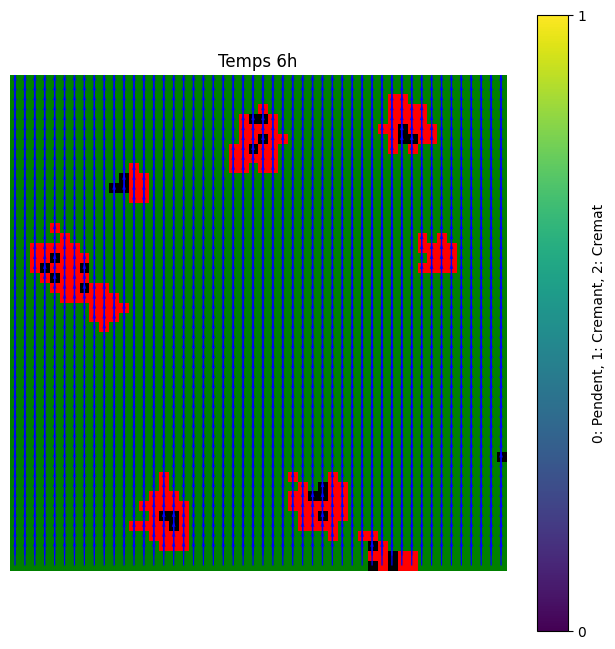

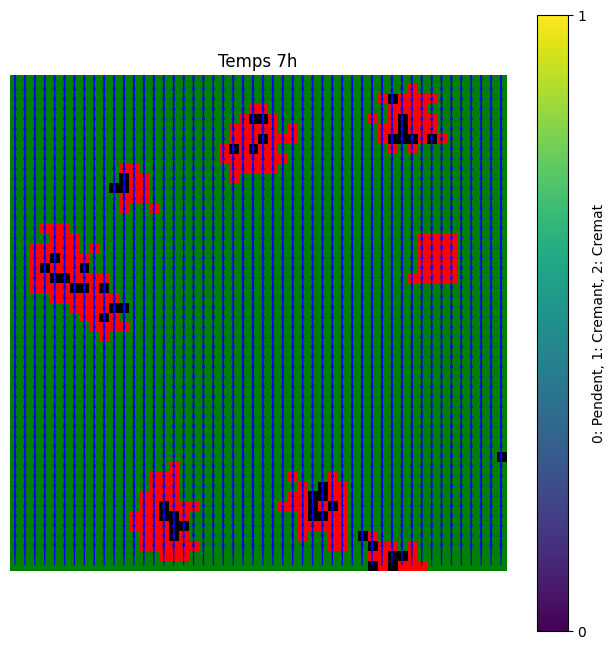

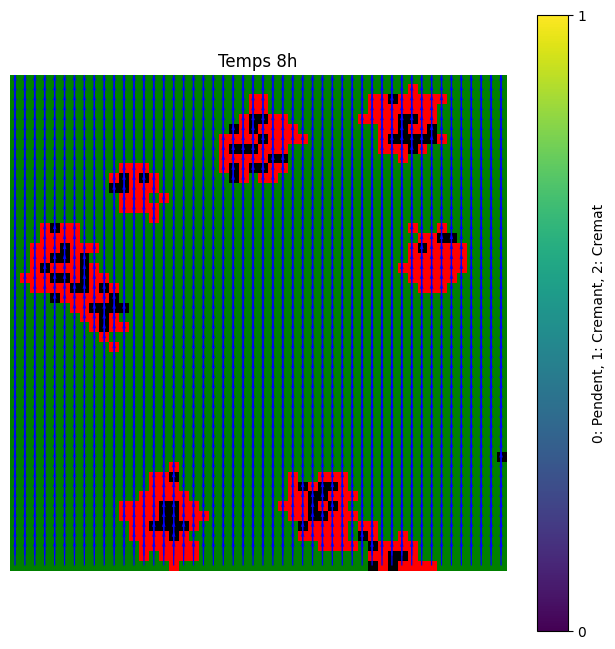

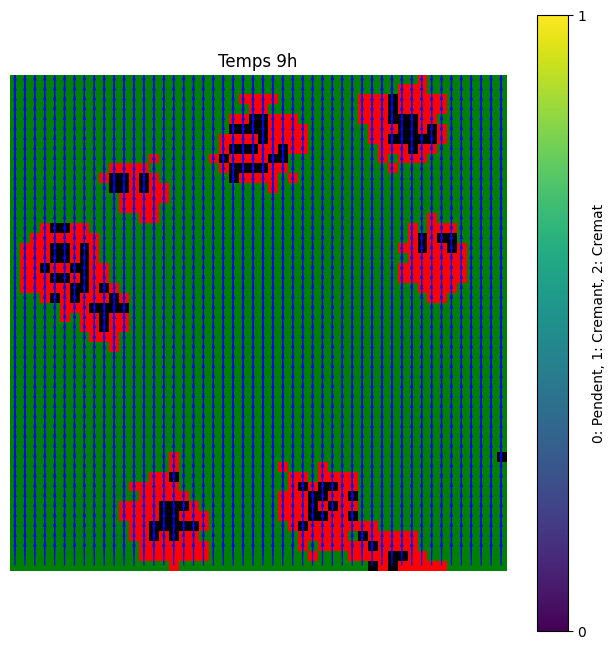

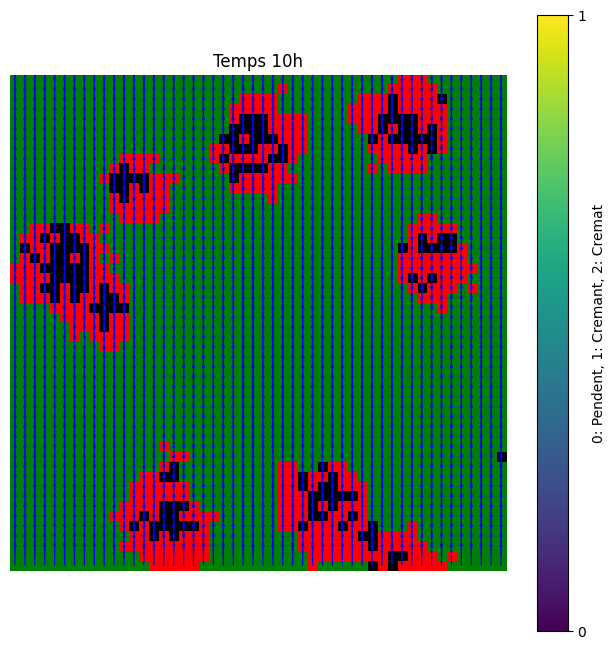

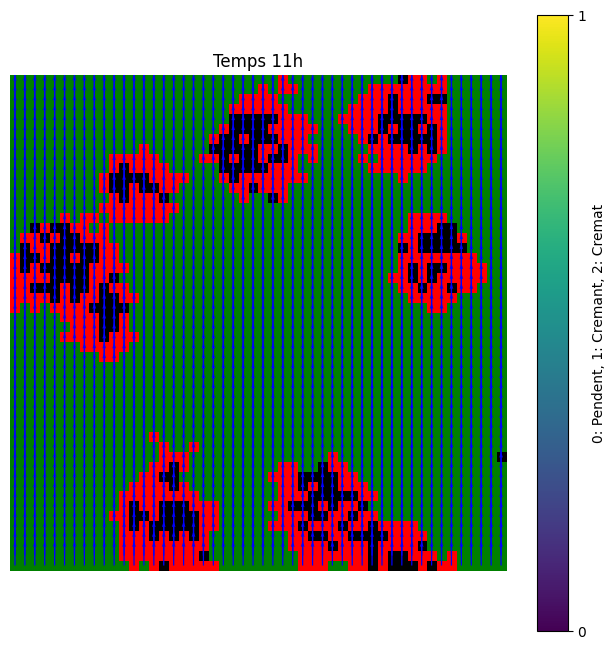

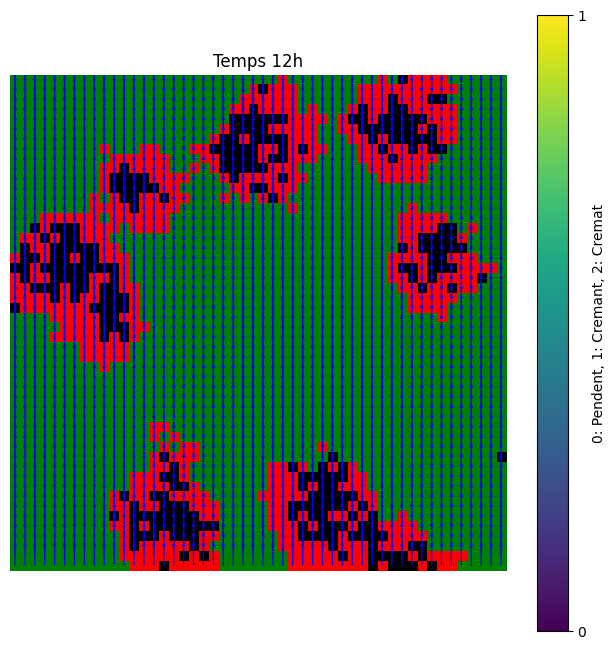

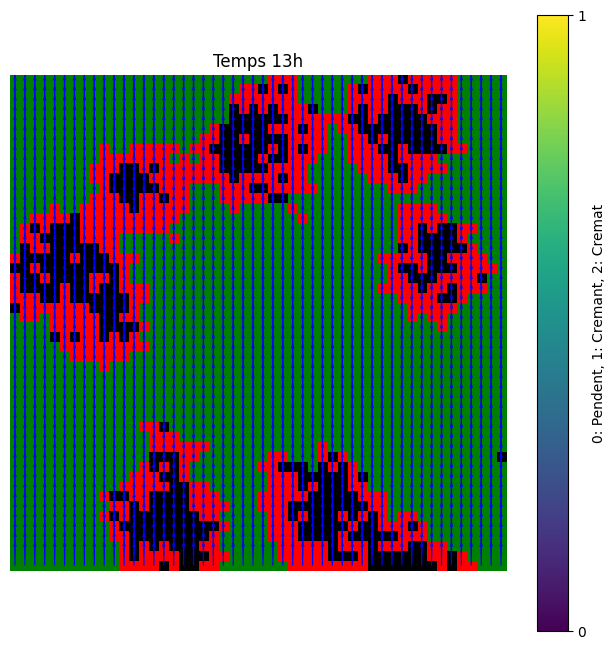

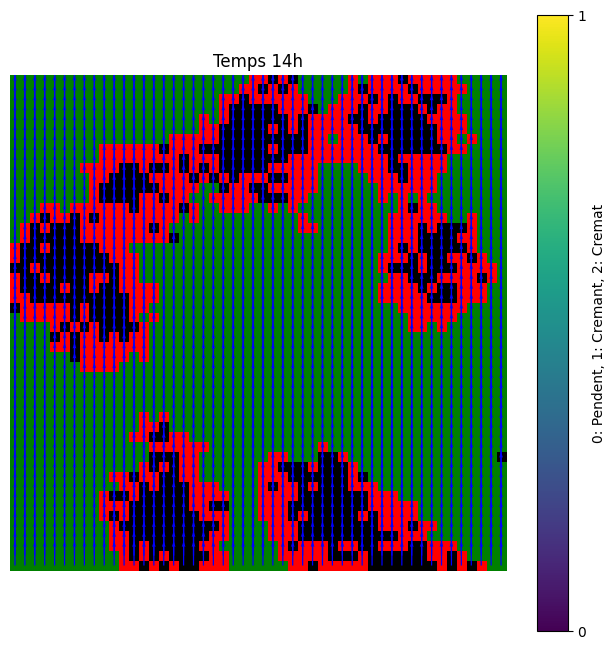

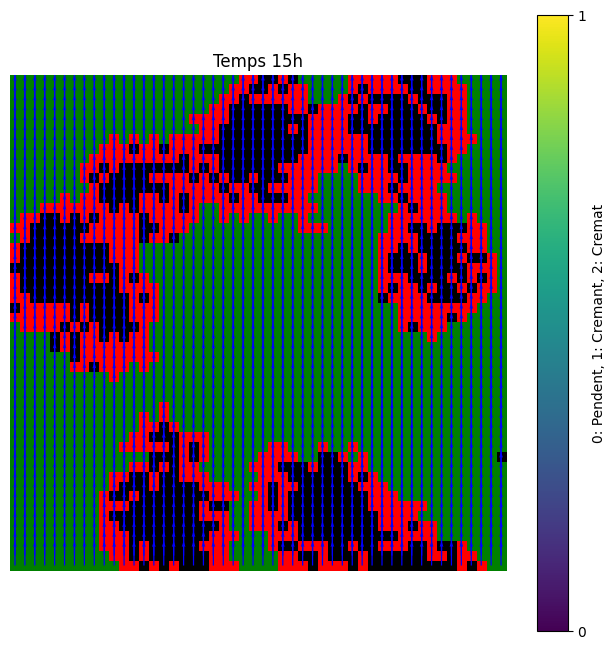

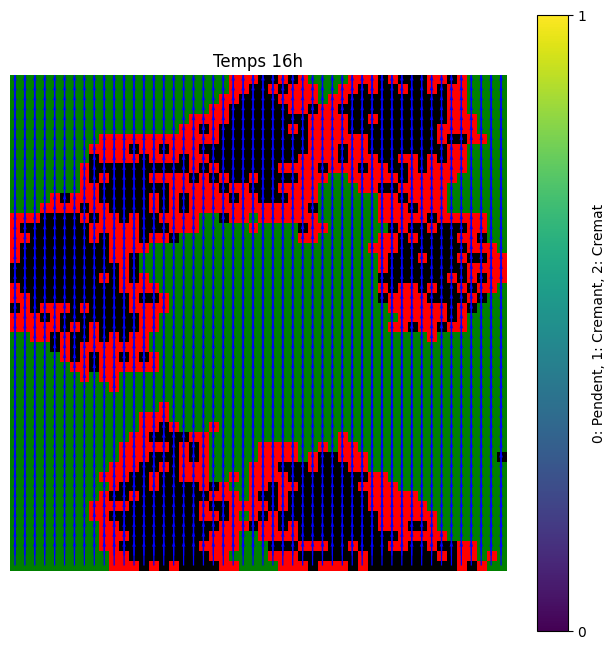

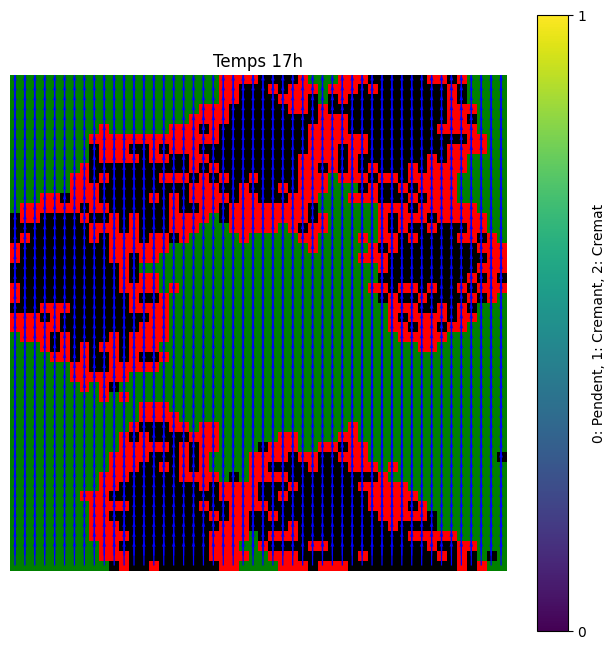

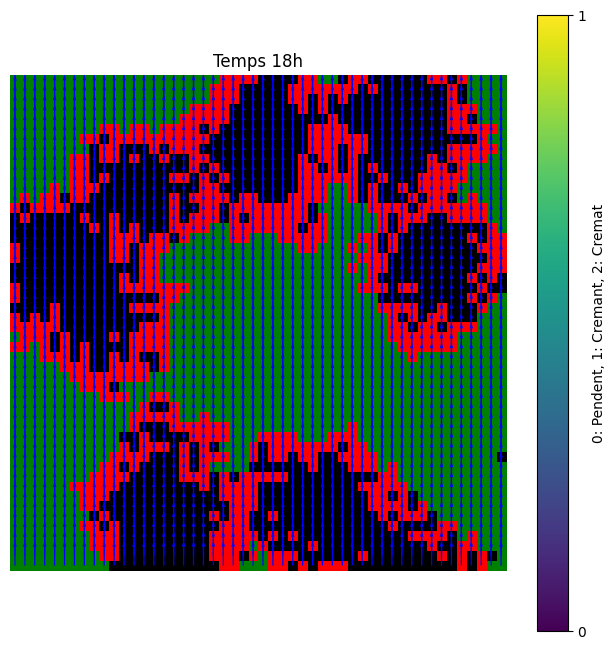

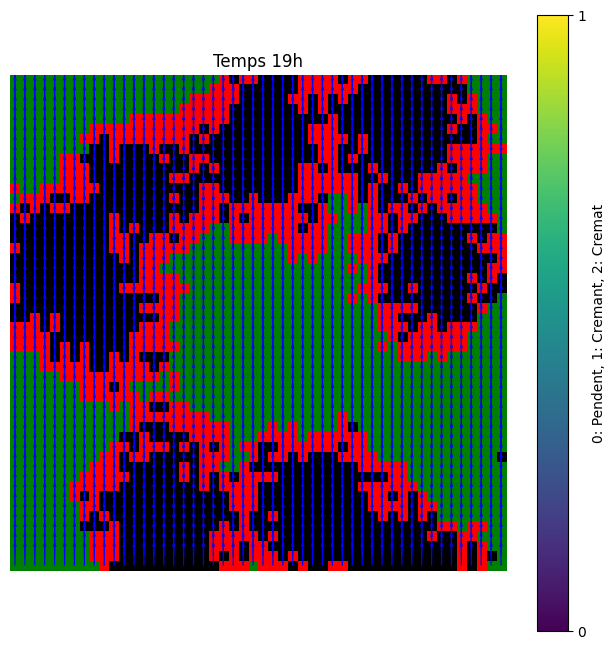

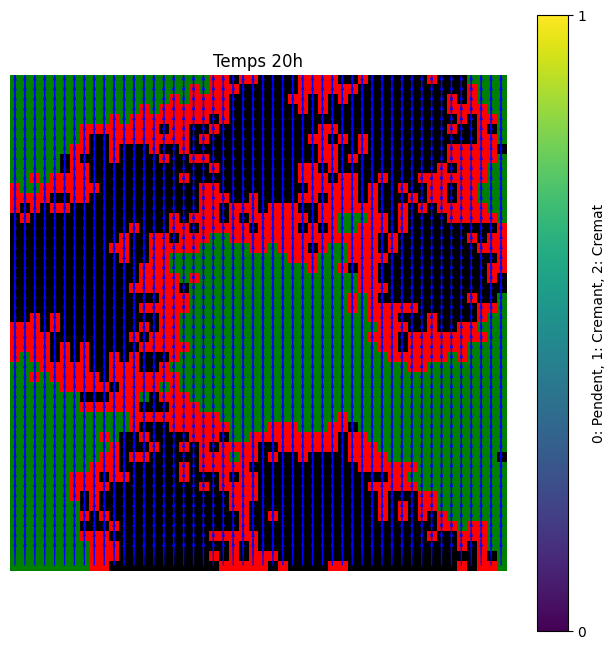

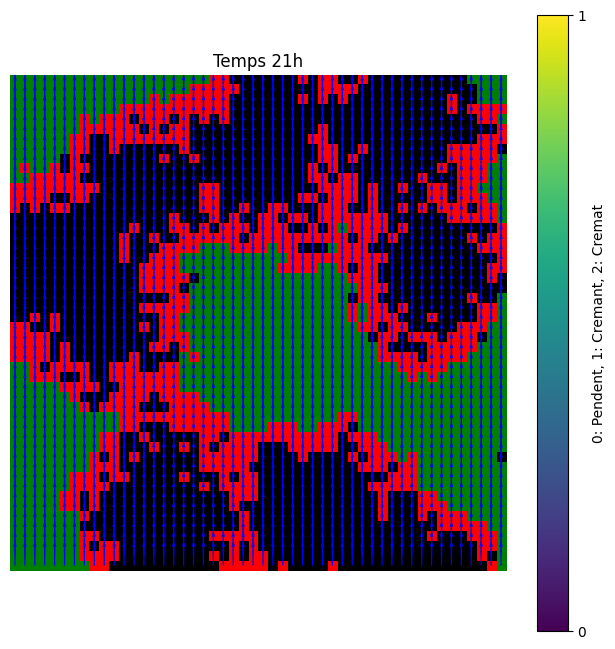

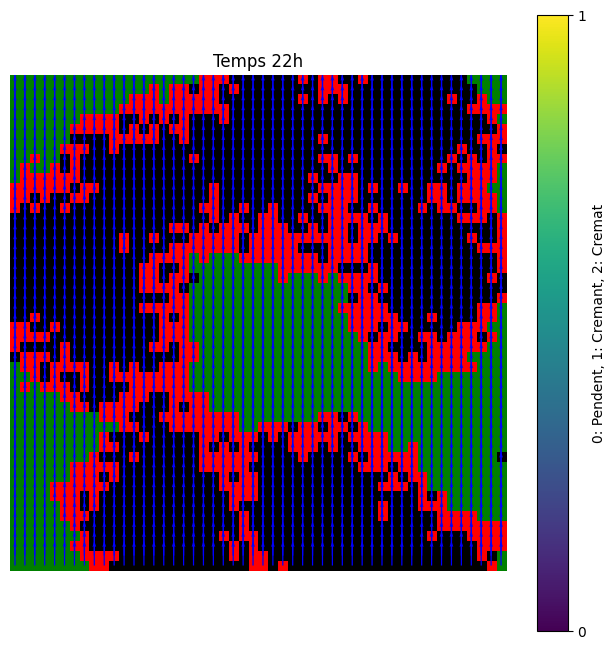

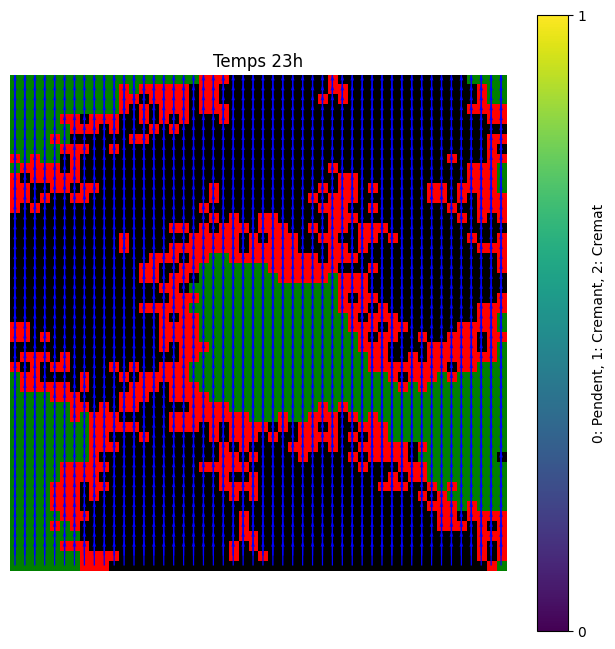

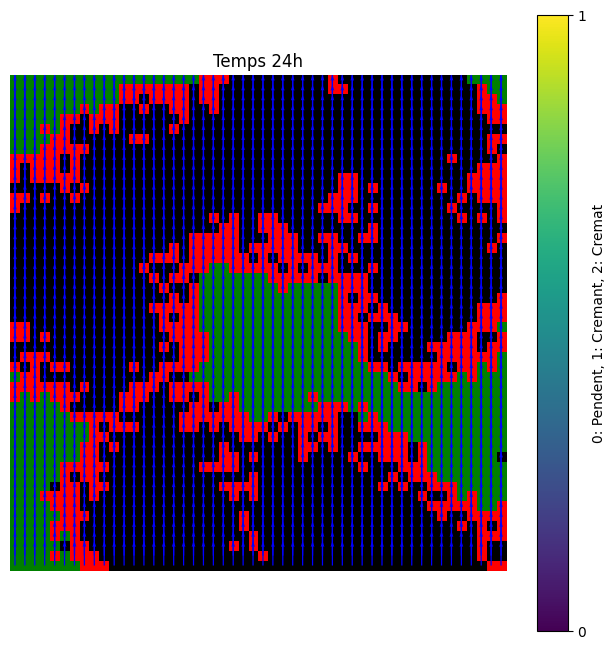

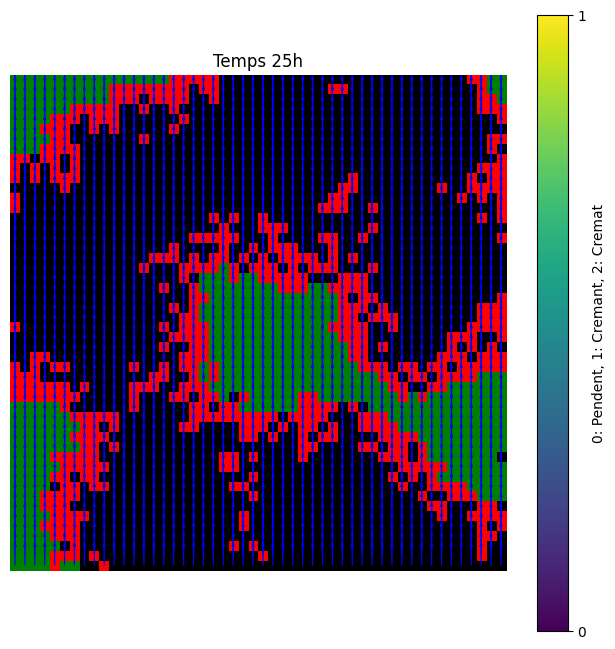

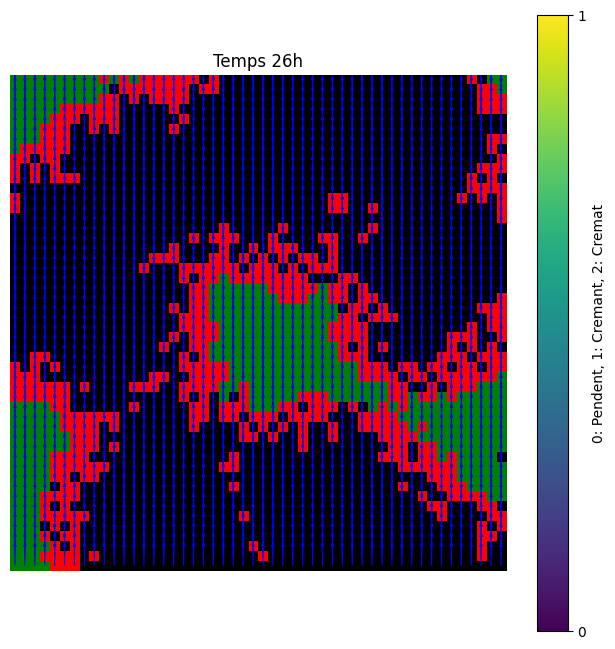

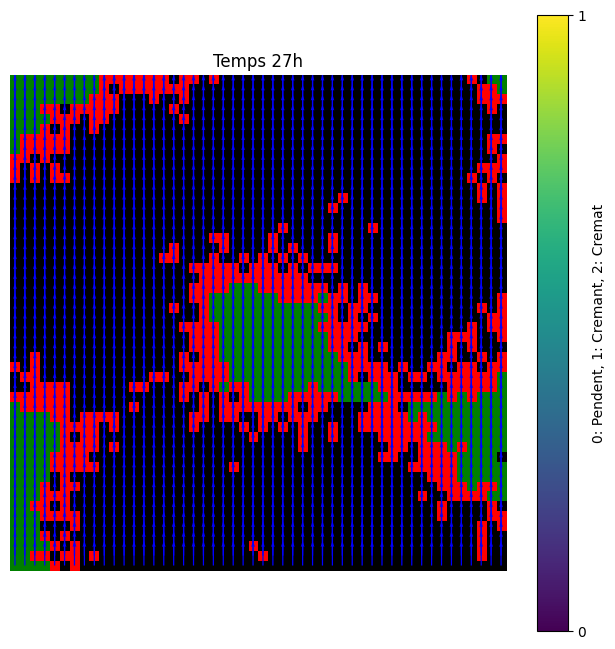

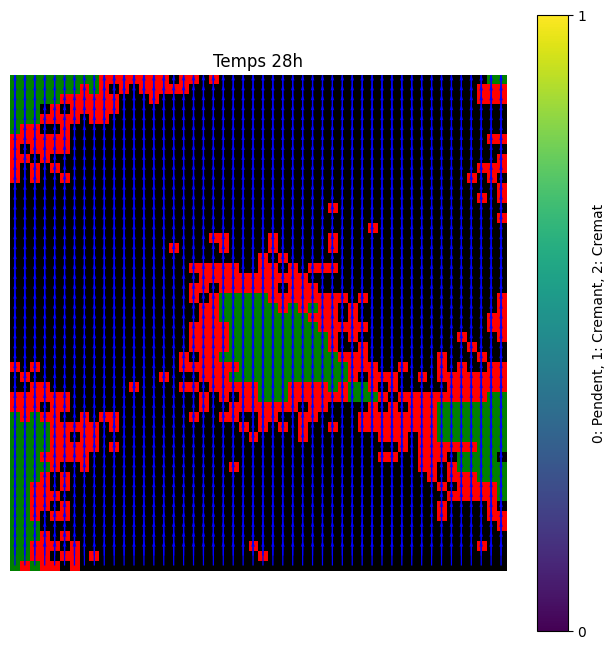

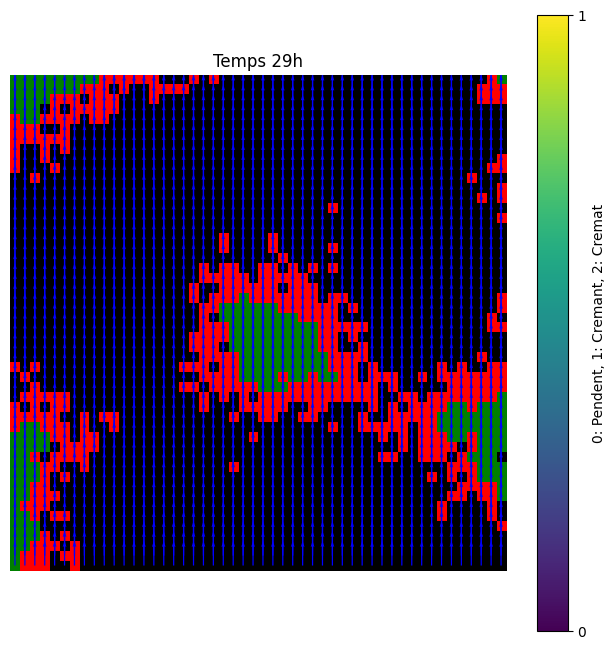

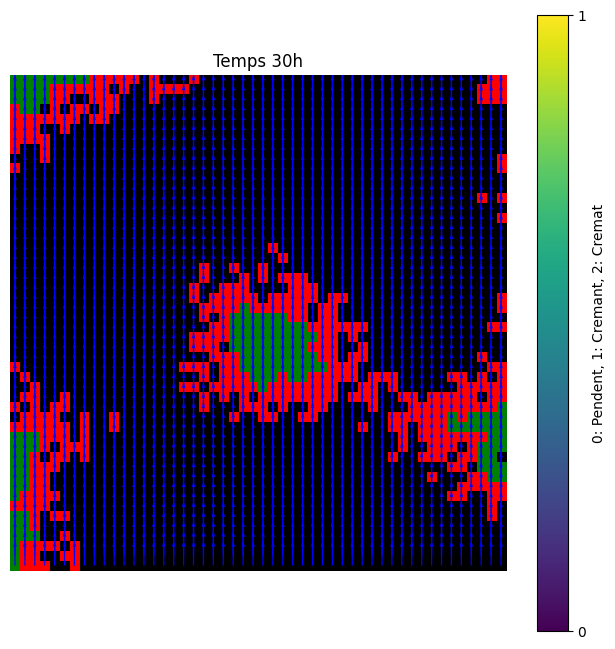

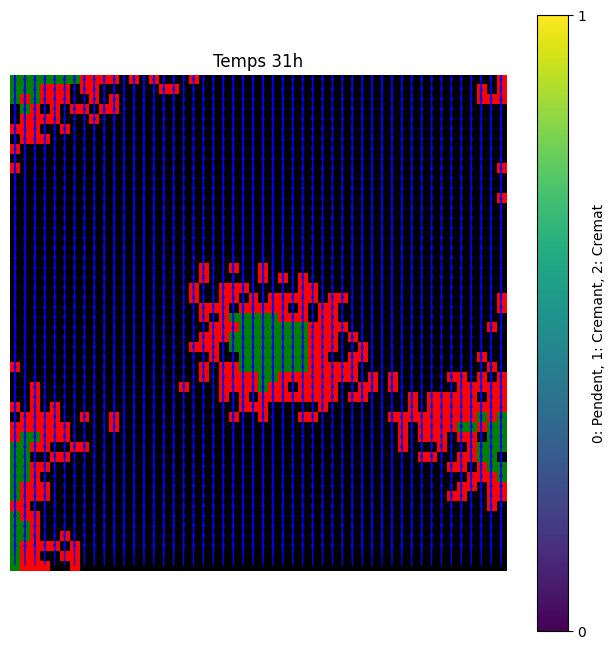

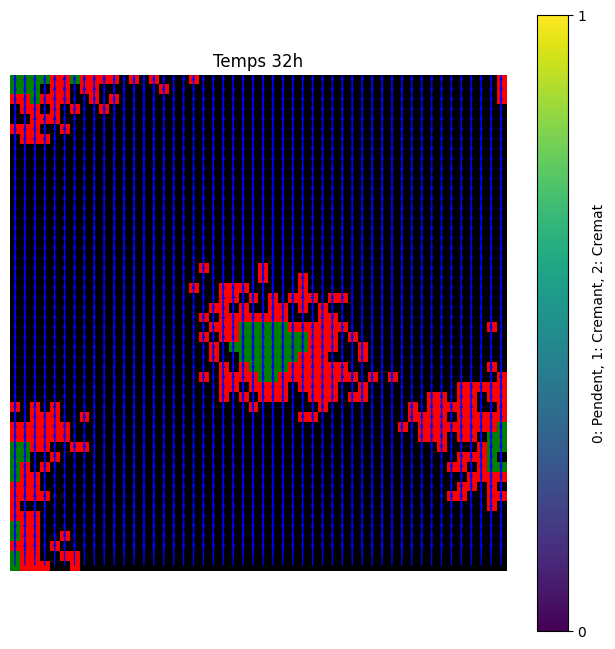

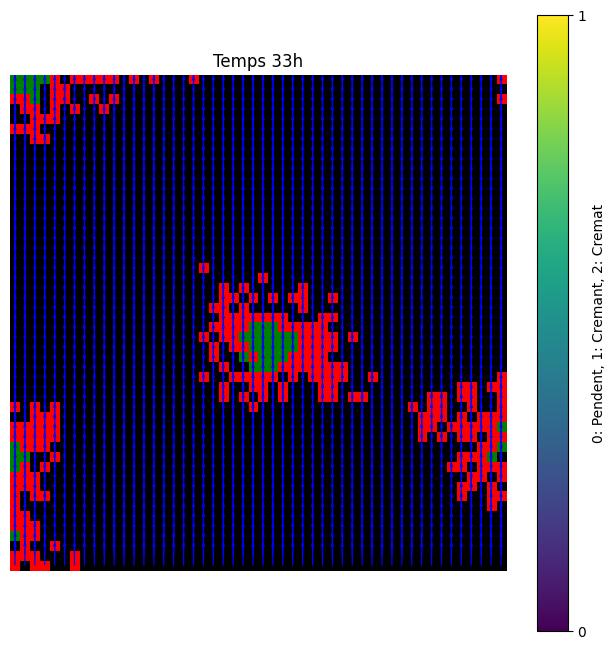

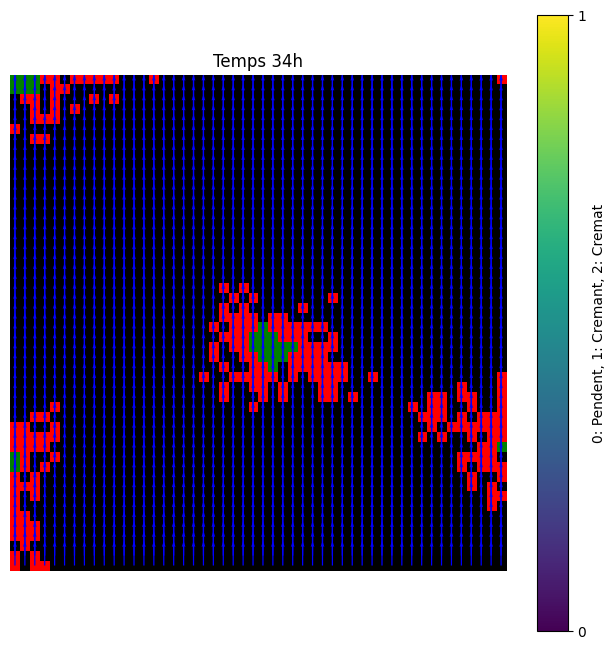

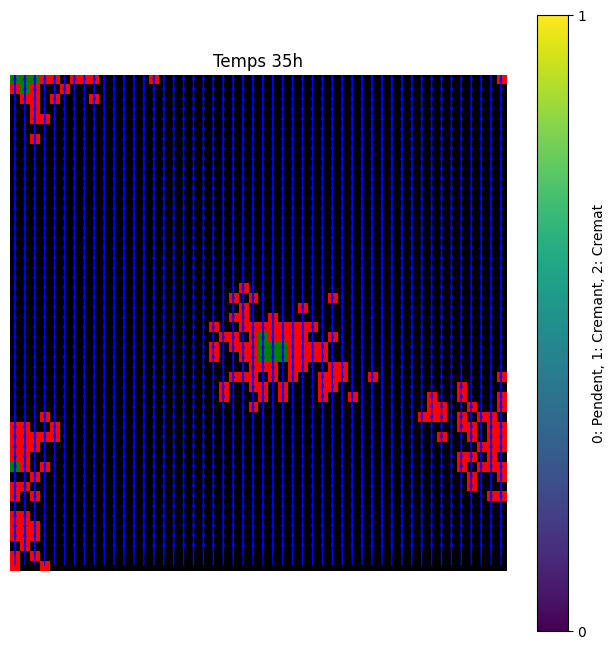

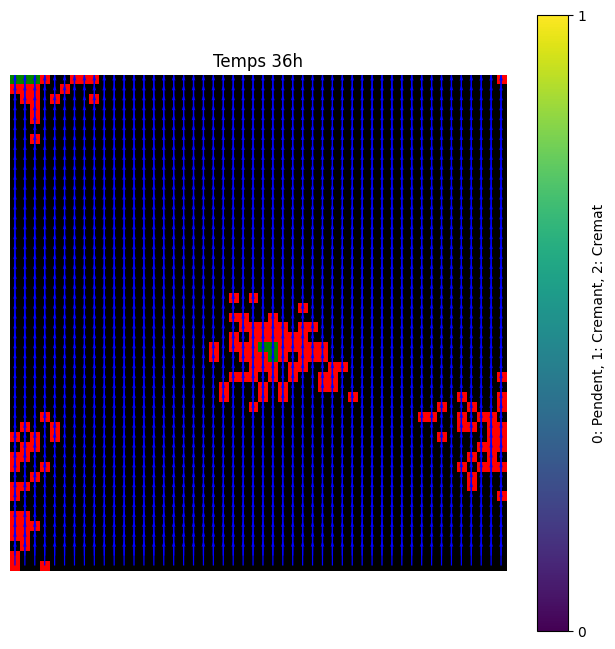

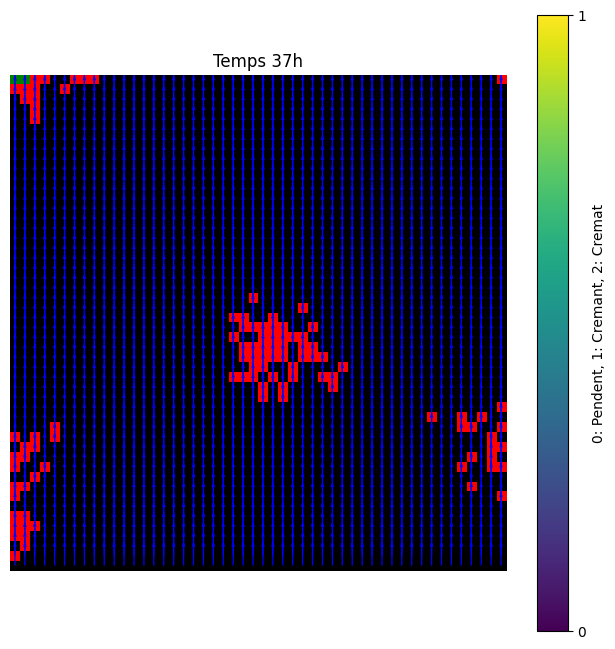

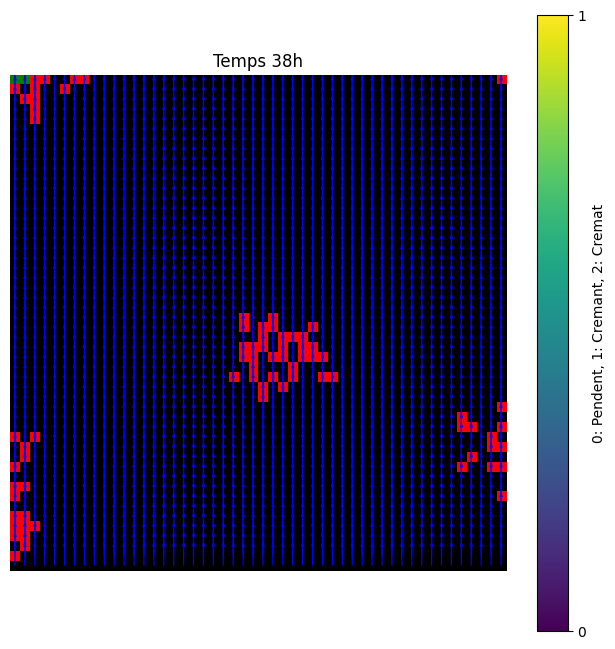

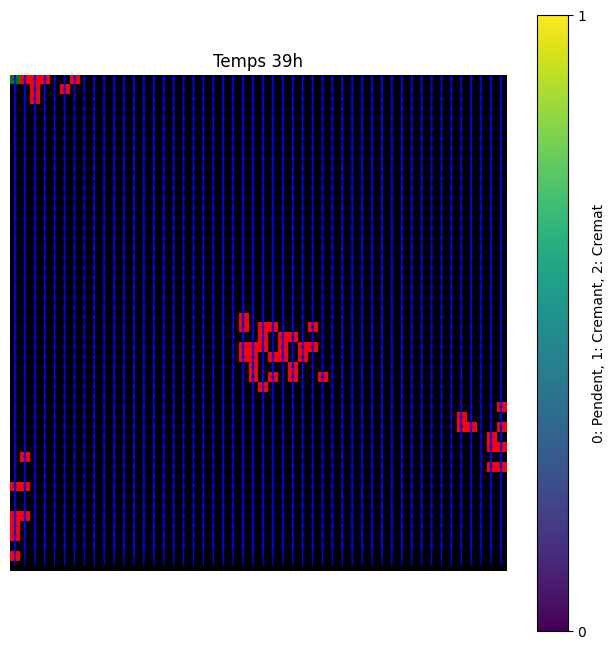

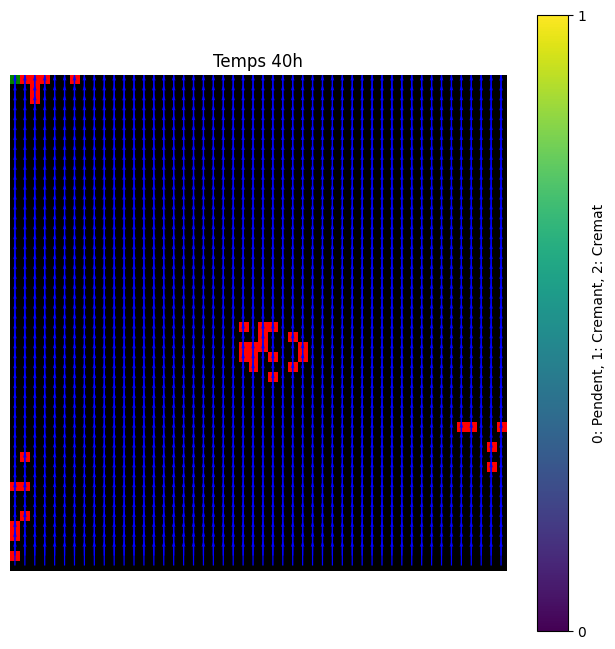

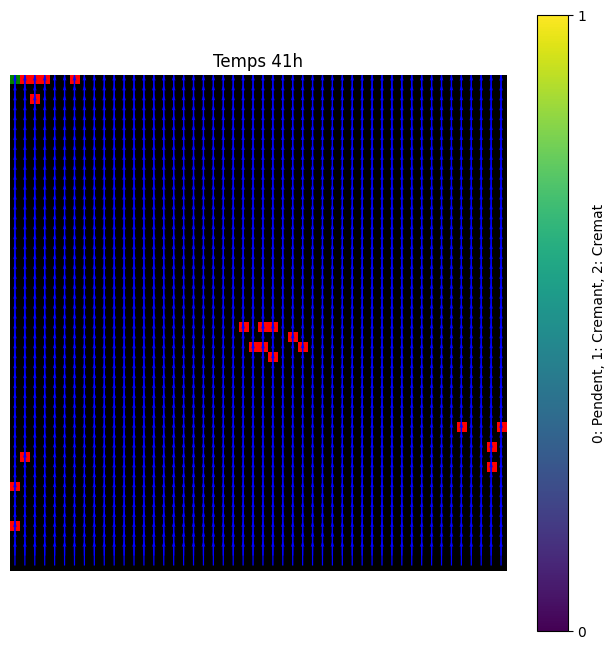

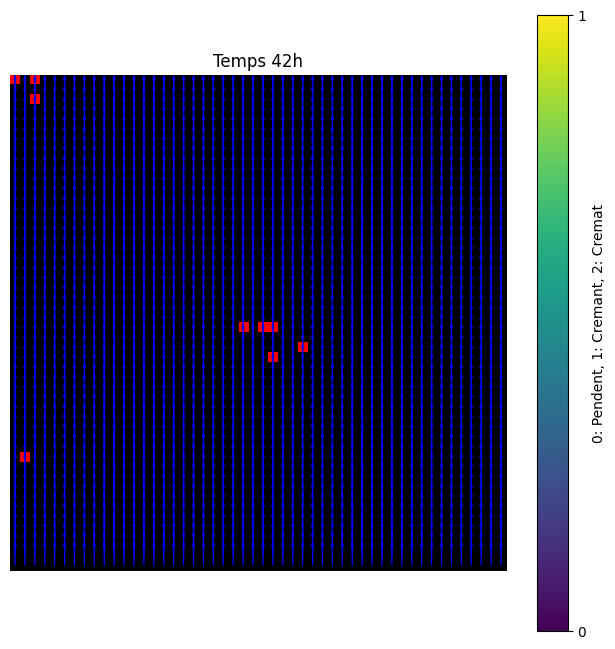

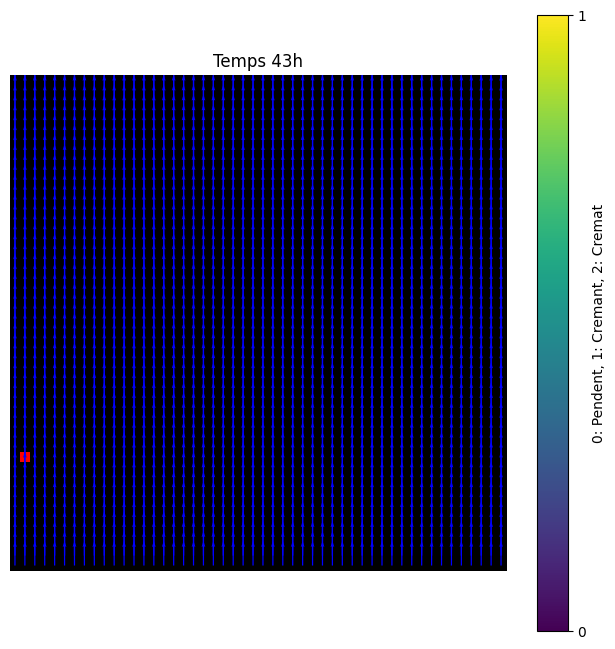

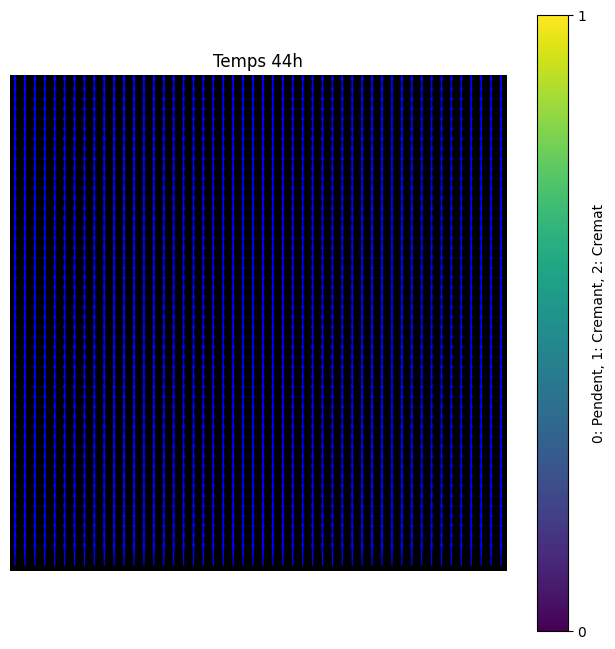

Incendi aturat per falta de propagació en 44 hores.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === 1. Funció per llegir fitxers .img (IDRISI32) ===
def read_img(path, shape):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data.reshape(shape)

# === 2. Inicialització ===

shape = (50, 50)

# Carreguem les capes
vegetation = read_img('vegetation.img', shape)
humidity = read_img('humidity.img', shape)

# Escollim direcció de vent global aleatòriament
wind_directions = {
    0: "Nord (↑)",
    1: "Nord-Est (↗)",
    2: "Est (→)",
    3: "Sud-Est (↘)",
    4: "Sud (↓)",
    5: "Sud-Oest (↙)",
    6: "Oest (←)",
    7: "Nord-Oest (↖)"
}
chosen_wind_dir = np.random.randint(0, 8)
wind = np.full(shape, chosen_wind_dir, dtype=np.int16)
print(f"Direcció del vent escollida: {wind_directions[chosen_wind_dir]}")

# Estat de les cel·les: 0 = pendent, 1 = cremant, 2 = cremat
state = np.zeros(shape, dtype=int)

# Inicialitzem foc en diversos punts aleatoris
num_initial_fires = 10
initial_fire_coords = np.random.choice(np.arange(shape[0]*shape[1]), num_initial_fires, replace=False)
for idx in initial_fire_coords:
    i, j = divmod(idx, shape[1])
    state[i, j] = 1

# Capes auxiliars per controlar humitat i vegetació cremant
humidity_timer = np.zeros_like(humidity)
vegetation_timer = np.zeros_like(vegetation)

# === 3. Nova funció d'actualització del foc amb VENT DES DE CEL·LA CREMANT ===
def update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer, wind):
    new_state = state.copy()
    new_humidity_timer = humidity_timer.copy()
    new_vegetation_timer = vegetation_timer.copy()

    directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]

    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if state[i, j] == 1:  # Cel·la que està cremant
                new_vegetation_timer[i, j] += 1
                if new_vegetation_timer[i, j] >= vegetation[i, j]:
                    new_state[i, j] = 2  # Ja està cremada

                wind_dir = wind[i, j]  # Direcció del vent a aquesta cel·la
                for d, (di, dj) in enumerate(directions):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < state.shape[0] and 0 <= nj < state.shape[1]:
                        if new_state[ni, nj] == 0:
                            # Propagació amb impuls
                            if d == wind_dir:
                                new_humidity_timer[ni, nj] += 2  # Direcció del vent
                            else:
                                new_humidity_timer[ni, nj] += 1

                            # Si s'ha superat la humitat, encén la cel·la
                            if new_humidity_timer[ni, nj] >= humidity[ni, nj]:
                                new_state[ni, nj] = 1

    return new_state, new_humidity_timer, new_vegetation_timer

# === 4. Funció per visualitzar l'estat amb fletxes de vent ===
def plot_state(state, step, wind):
    cmap = colors.ListedColormap(['green', 'red', 'black'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8,8))
    plt.imshow(state, cmap=cmap, norm=norm)
    plt.title(f'Temps {step}h')

    direction_vectors = {
        0: (-1, 0),  # Nord
        1: (-1, 1),  # Nord-Est
        2: (0, 1),   # Est
        3: (1, 1),   # Sud-Est
        4: (1, 0),   # Sud
        5: (1, -1),  # Sud-Oest
        6: (0, -1),  # Oest
        7: (-1, -1)  # Nord-Oest
    }

    X, Y = np.meshgrid(np.arange(state.shape[1]), np.arange(state.shape[0]))
    U = np.zeros_like(wind, dtype=float)
    V = np.zeros_like(wind, dtype=float)

    for code, (di, dj) in direction_vectors.items():
        mask = (wind == code)
        V[mask] = di
        U[mask] = dj

    plt.quiver(X, Y, U, V, color='blue', scale=20, width=0.0025)
    plt.colorbar(ticks=[0,1,2], label='0: Pendent, 1: Cremant, 2: Cremat')
    plt.axis('off')
    plt.show()

# === 5. Simulació ===
max_steps = 100
for step in range(max_steps):
    plot_state(state, step, wind)
    next_state, next_humidity_timer, next_vegetation_timer = update_fire(
        state, humidity, vegetation, humidity_timer, vegetation_timer, wind
    )

    if np.array_equal(next_state, state):
        print(f"Incendi aturat per falta de propagació en {step} hores.")
        break

    state = next_state
    humidity_timer = next_humidity_timer
    vegetation_timer = next_vegetation_timer
